In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pansharpening/valid_wv3_9714.h5
/kaggle/input/pansharpening/test_wv3_multiExm1.h5
/kaggle/input/pansharpening/test_gf2_OrigScale_multiExm1.h5
/kaggle/input/pansharpening/test_qb_OrigScale_multiExm1.h5
/kaggle/input/pansharpening/train_wv3_9714.h5
/kaggle/input/pansharpening/valid_qb_17139.h5
/kaggle/input/pansharpening/train_qb_17139.h5
/kaggle/input/pansharpening/train_gf2_19809.h5
/kaggle/input/pansharpening/valid_gf2_19809.h5


In [26]:
# Install required packages
!pip install h5py torch tensorflow scikit-image pandas matplotlib tqdm -q

import os
import csv
import json
import h5py
import torch
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

print("\n" + "="*70)
print("✅ ALL PACKAGES INSTALLED SUCCESSFULLY")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")



✅ ALL PACKAGES INSTALLED SUCCESSFULLY
PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0
GPU Available: True
GPU Name: Tesla P100-PCIE-16GB


In [27]:
# ─────────────────────────────────────────────────────────────────
# CONFIGURATION SETTINGS
# ─────────────────────────────────────────────────────────────────

SATELLITE = "WV3"  # Single satellite (your modification)
NUM_BANDS = 8      # WorldView-3 has 8 bands
BATCH_SIZE = 16
NUM_EPOCHS = 100   # Adjust based on time (start with 100, can increase to 500+)
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# Device selection
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────────────────────────────────────────
# DATA PATHS
# ─────────────────────────────────────────────────────────────────

DATASET_PATH = "/kaggle/input/pansharpening"  # Your dataset name
train_h5_path = f"{DATASET_PATH}/train_wv3_9714.h5"
valid_h5_path = f"{DATASET_PATH}/valid_wv3_9714.h5"
test_h5_path = f"{DATASET_PATH}/test_wv3_multiExm1.h5"
OUTPUT_PATH = "/kaggle/working"

# ─────────────────────────────────────────────────────────────────
# RESULTS STORAGE
# ─────────────────────────────────────────────────────────────────

results = {
    "satellite": SATELLITE,
    "timestamp": datetime.now().isoformat(),
    "num_epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "model1": {},  # CBAMParallelUNet
    "model2": {}   # EnhancedCBAMTransformerUNet
}

print("\n" + "="*70)
print("CONFIGURATION SUMMARY")
print("="*70)
print(f"Satellite: {SATELLITE}")
print(f"Device: {DEVICE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Dataset Path: {DATASET_PATH}")
print("="*70)



CONFIGURATION SUMMARY
Satellite: WV3
Device: cuda
Batch Size: 16
Epochs: 100
Learning Rate: 0.0001
Dataset Path: /kaggle/input/pansharpening


In [28]:
print("\n" + "="*70)
print("LOADING DATASETS AND COMPUTING STATISTICS")
print("="*70)

# ─────────────────────────────────────────────────────────────────
# FUNCTION: Compute normalization statistics
# ─────────────────────────────────────────────────────────────────

def compute_stats(h5_path, max_samples=200):
    """
    Compute mean and std for normalization
    Uses up to max_samples for efficiency
    """
    print(f"\nComputing stats from {h5_path}...")
    
    with h5py.File(h5_path, 'r') as f:
        n = min(max_samples, f['pan'].shape[0])
        
        pan = f['pan'][:n]
        ms = f['ms'][:n]
        gt = f['gt'][:n]
    
    # Compute statistics
    pan_mean = float(np.mean(pan))
    pan_std = float(np.std(pan))
    ms_mean = np.mean(ms, axis=(0, 2, 3)).astype(np.float32)
    ms_std = np.std(ms, axis=(0, 2, 3)).astype(np.float32)
    gt_mean = np.mean(gt, axis=(0, 2, 3)).astype(np.float32)
    gt_std = np.std(gt, axis=(0, 2, 3)).astype(np.float32)
    
    print(f"   ✅ Stats computed from {n} samples")
    return pan_mean, pan_std, ms_mean, ms_std, gt_mean, gt_std

# Compute statistics
pan_mean, pan_std, ms_mean, ms_std, gt_mean, gt_std = compute_stats(train_h5_path)

print(f"\n✅ Statistics Summary:")
print(f"   PAN - Mean: {pan_mean:.2f}, Std: {pan_std:.2f}")
print(f"   MS - Mean: {ms_mean[:2]}, Std: {ms_std[:2]}")

# ─────────────────────────────────────────────────────────────────
# FUNCTION: Normalize data
# ─────────────────────────────────────────────────────────────────

def normalize(pan, ms, gt):
    """Normalize pan, ms, gt using computed statistics"""
    eps = 1e-6
    pan_norm = (pan - pan_mean) / (pan_std + eps)
    ms_norm = (ms - ms_mean[:, None, None]) / (ms_std[:, None, None] + eps)
    gt_norm = (gt - gt_mean[:, None, None]) / (gt_std[:, None, None] + eps)
    return pan_norm, ms_norm, gt_norm

# ─────────────────────────────────────────────────────────────────
# LOAD ALL DATASETS
# ─────────────────────────────────────────────────────────────────

print("\n" + "-"*70)
print("Loading and normalizing datasets...")
print("-"*70)

# Load training data
with h5py.File(train_h5_path, 'r') as f:
    train_pan = f['pan'][:]
    train_ms = f['ms'][:]
    train_gt = f['gt'][:]

# Load validation data
with h5py.File(valid_h5_path, 'r') as f:
    valid_pan = f['pan'][:]
    valid_ms = f['ms'][:]
    valid_gt = f['gt'][:]

# Load test data
with h5py.File(test_h5_path, 'r') as f:
    test_pan = f['pan'][:]
    test_ms = f['ms'][:]
    test_gt = f['gt'][:]

# Normalize all datasets
train_pan, train_ms, train_gt = normalize(train_pan, train_ms, train_gt)
valid_pan, valid_ms, valid_gt = normalize(valid_pan, valid_ms, valid_gt)
test_pan, test_ms, test_gt = normalize(test_pan, test_ms, test_gt)

print(f"\n✅ Datasets Loaded and Normalized:")
print(f"   Training: {train_pan.shape[0]} samples")
print(f"   Validation: {valid_pan.shape[0]} samples")
print(f"   Test: {test_pan.shape[0]} samples")

# Store stats tuple for later use
stats_tuple = (pan_mean, pan_std, ms_mean, ms_std, gt_mean, gt_std)



LOADING DATASETS AND COMPUTING STATISTICS

Computing stats from /kaggle/input/pansharpening/train_wv3_9714.h5...
   ✅ Stats computed from 200 samples

✅ Statistics Summary:
   PAN - Mean: 396.26, Std: 224.74
   MS - Mean: [278.2048 313.0585], Std: [ 78.52115 124.71192]

----------------------------------------------------------------------
Loading and normalizing datasets...
----------------------------------------------------------------------

✅ Datasets Loaded and Normalized:
   Training: 9714 samples
   Validation: 1080 samples
   Test: 20 samples


In [29]:
print("\n" + "="*70)
print("DEFINING CBAM ATTENTION MODULES")
print("="*70)

# ─────────────────────────────────────────────────────────────────
# CBAM: Channel Attention Module
# ─────────────────────────────────────────────────────────────────

class ChannelAttention(torch.nn.Module):
    """
    Channel Attention Module
    Recalibrates channel-wise feature responses
    """
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.max_pool = torch.nn.AdaptiveMaxPool2d(1)
        
        # Shared MLP
        self.fc = torch.nn.Sequential(
            torch.nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

# ─────────────────────────────────────────────────────────────────
# CBAM: Spatial Attention Module
# ─────────────────────────────────────────────────────────────────

class SpatialAttention(torch.nn.Module):
    """
    Spatial Attention Module
    Recalibrates spatial-wise feature responses
    """
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = torch.nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

# ─────────────────────────────────────────────────────────────────
# CBAM: Complete Convolutional Block Attention Module
# ─────────────────────────────────────────────────────────────────

class CBAM(torch.nn.Module):
    """
    Convolutional Block Attention Module
    Combines channel and spatial attention
    """
    def __init__(self, in_channels, reduction_ratio=8):
        super().__init__()
        self.ca = ChannelAttention(in_channels, ratio=reduction_ratio)
        self.sa = SpatialAttention(kernel_size=7)
    
    def forward(self, x):
        # Apply channel attention
        x = x * self.ca(x)
        # Apply spatial attention
        x = x * self.sa(x)
        return x

print("✅ CBAM modules defined successfully")



DEFINING CBAM ATTENTION MODULES
✅ CBAM modules defined successfully


In [30]:
print("\n" + "="*70)
print("DEFINING MODEL 1: CBAMParallelUNet (CORRECTED)")
print("="*70)

class CBAMParallelUNet(torch.nn.Module):
    """
    CBAMParallelUNet - Parallel processing of PAN and MS
    with CBAM attention at multiple scales
    CORRECTED: Fixed decoder skip connections
    """
    
    def __init__(self, in_pan=1, in_ms=8, out_ch=8, base_ch=64):
        super().__init__()
        
        # ─ PAN Encoder
        self.pan_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_pan, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch)
        )
        
        # ─ MS Encoder
        self.ms_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_ms, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch)
        )
        
        self.pool = torch.nn.MaxPool2d(2)
        
        # ─ Combined Encoder
        self.combined_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 2, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch * 2, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch * 2)
        )
        
        # ─ Bottleneck
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 2, base_ch * 4, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch * 4, base_ch * 4, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch * 4)
        )
        
        # ─ Decoder (CORRECTED)
        self.up1 = torch.nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec1 = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 4, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch * 2, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch * 2)
        )
        
        self.up2 = torch.nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec2 = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 2, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch)
        )
        
        # ─ Output
        self.final = torch.nn.Conv2d(base_ch, out_ch, 1)
    
    def forward(self, pan, ms):
        """
        CORRECTED forward pass with proper skip connections
        """
        # Upsample MS
        if ms.shape[2:] != pan.shape[2:]:
            ms = torch.nn.functional.interpolate(
                ms, size=pan.shape[2:], mode='bilinear', align_corners=False
            )
        
        # ─ Encoder: PAN and MS processing
        pan_feat1 = self.pan_encoder(pan)  # [N, 64, 64, 64]
        ms_feat1 = self.ms_encoder(ms)      # [N, 64, 64, 64]
        
        # ─ Pool and combine
        pan_feat1_pool = self.pool(pan_feat1)  # [N, 64, 32, 32]
        ms_feat1_pool = self.pool(ms_feat1)    # [N, 64, 32, 32]
        
        x = torch.cat([pan_feat1_pool, ms_feat1_pool], dim=1)  # [N, 128, 32, 32]
        x = self.combined_encoder(x)  # [N, 128, 32, 32]
        x_enc2 = x  # SAVE for skip connection
        
        # ─ Bottleneck
        x = self.pool(x)  # [N, 128, 16, 16]
        x = self.bottleneck(x)  # [N, 256, 16, 16]
        
        # ─ Decoder (FIXED)
        # Up sample to 32x32
        x = self.up1(x)  # [N, 128, 32, 32]
        
        # IMPORTANT: Make sure x_enc2 has matching spatial dims before concat
        if x.shape[2:] != x_enc2.shape[2:]:
            x_enc2 = torch.nn.functional.interpolate(
                x_enc2, size=x.shape[2:], mode='bilinear', align_corners=False
            )
        
        x = torch.cat([x, x_enc2], dim=1)  # [N, 256, 32, 32]
        x = self.dec1(x)  # [N, 128, 32, 32]
        
        # Up sample to 64x64
        x = self.up2(x)  # [N, 64, 64, 64]
        
        # Skip connection with pan_feat1_pool needs upsampling
        pan_feat1_pool_up = torch.nn.functional.interpolate(
            pan_feat1_pool, size=x.shape[2:], mode='bilinear', align_corners=False
        )
        
        x = torch.cat([x, pan_feat1_pool_up], dim=1)  # [N, 128, 64, 64]
        x = self.dec2(x)  # [N, 64, 64, 64]
        
        return self.final(x)  # [N, 8, 64, 64]

model1 = CBAMParallelUNet(1, NUM_BANDS, NUM_BANDS, 64).to(DEVICE)
params1 = sum(p.numel() for p in model1.parameters())

print(f"✅ Model 1 Created Successfully (CORRECTED)")
print(f"   Architecture: CBAMParallelUNet")
print(f"   Parameters: {params1:,} ({params1/1e6:.2f}M)")
print(f"   Device: {DEVICE}")



DEFINING MODEL 1: CBAMParallelUNet (CORRECTED)
✅ Model 1 Created Successfully (CORRECTED)
   Architecture: CBAMParallelUNet
   Parameters: 2,005,716 (2.01M)
   Device: cuda


In [31]:
print("\n" + "="*70)
print("DEFINING MODEL 2: EnhancedCBAMTransformerUNet (FULLY CORRECTED)")
print("="*70)

class TransformerBlock(torch.nn.Module):
    """Transformer Block using Multi-Head Self-Attention"""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(channels)
        self.attn = torch.nn.MultiheadAttention(channels, num_heads, batch_first=True)
        self.norm2 = torch.nn.LayerNorm(channels)
        self.ff = torch.nn.Sequential(
            torch.nn.Linear(channels, channels * 2),
            torch.nn.ReLU(inplace=False),
            torch.nn.Linear(channels * 2, channels)
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        x_reshape = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        attn_out, _ = self.attn(x_reshape, x_reshape, x_reshape)
        x_reshape = x_reshape + attn_out
        ff_out = self.ff(self.norm2(x_reshape))
        x_reshape = x_reshape + ff_out
        return x_reshape.reshape(B, H, W, C).permute(0, 3, 1, 2)

class EnhancedCBAMTransformerUNet(torch.nn.Module):
    """
    Enhanced CBAM Transformer UNet - COMPLETE CORRECTED VERSION
    Fixes all decoder issues
    """
    
    def __init__(self, in_pan=1, in_ms=8, out_ch=8, base_ch=64):
        super().__init__()
        
        # Encoder blocks
        self.pan_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_pan, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch)
        )
        
        self.ms_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_ms, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch)
        )
        
        self.pool = torch.nn.MaxPool2d(2)
        
        self.combined_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 2, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch * 2, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch * 2)
        )
        
        # Transformer
        self.transformer = TransformerBlock(base_ch * 2, num_heads=4)
        
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 2, base_ch * 4, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch * 4, base_ch * 4, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch * 4)
        )
        
        # CORRECTED Decoder
        self.up1 = torch.nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec1 = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 4, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch * 2, base_ch * 2, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch * 2)
        )
        
        self.up2 = torch.nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec2 = torch.nn.Sequential(
            torch.nn.Conv2d(base_ch * 2, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(base_ch, base_ch, 3, padding=1),
            torch.nn.ReLU(inplace=False),
            CBAM(base_ch)
        )
        
        self.final = torch.nn.Conv2d(base_ch, out_ch, 1)
    
    def forward(self, pan, ms):
        # Upsample MS if needed
        if ms.shape[2:] != pan.shape[2:]:
            ms = torch.nn.functional.interpolate(ms, size=pan.shape[2:], mode='bilinear', align_corners=False)
        
        # ─ ENCODER STAGE 1
        pan_e1 = self.pan_encoder(pan)  # [N, 64, 64, 64]
        ms_e1 = self.ms_encoder(ms)      # [N, 64, 64, 64]
        
        # ─ POOL & COMBINE
        pan_e1_p = self.pool(pan_e1)  # [N, 64, 32, 32]
        ms_e1_p = self.pool(ms_e1)    # [N, 64, 32, 32]
        
        x = torch.cat([pan_e1_p, ms_e1_p], dim=1)  # [N, 128, 32, 32]
        x = self.combined_encoder(x)  # [N, 128, 32, 32]
        
        # ★ TRANSFORMER (Key feature!)
        x = self.transformer(x)  # [N, 128, 32, 32]
        skip_32x32 = x  # SAVE for decoder
        
        # ─ BOTTLENECK
        x = self.pool(x)  # [N, 128, 16, 16]
        x = self.bottleneck(x)  # [N, 256, 16, 16]
        
        # ─ DECODER (CORRECTED - NO MORE ERRORS!)
        # UP to 32x32
        x = self.up1(x)  # [N, 128, 32, 32]
        
        # Ensure skip has same spatial dims
        skip_32x32 = torch.nn.functional.interpolate(
            skip_32x32, size=x.shape[2:], mode='bilinear', align_corners=False
        )
        
        x = torch.cat([x, skip_32x32], dim=1)  # [N, 256, 32, 32]
        x = self.dec1(x)  # [N, 128, 32, 32]
        
        # UP to 64x64
        x = self.up2(x)  # [N, 64, 64, 64]
        
        # Ensure pan_e1_p skip has same spatial dims (IMPORTANT!)
        pan_e1_p_up = torch.nn.functional.interpolate(
            pan_e1_p, size=x.shape[2:], mode='bilinear', align_corners=False
        )
        
        x = torch.cat([x, pan_e1_p_up], dim=1)  # [N, 128, 64, 64]
        x = self.dec2(x)  # [N, 64, 64, 64]
        
        return self.final(x)  # [N, 8, 64, 64]

model2 = EnhancedCBAMTransformerUNet(1, NUM_BANDS, NUM_BANDS, 64).to(DEVICE)
params2 = sum(p.numel() for p in model2.parameters())

print(f"✅ Model 2 Created Successfully (FULLY CORRECTED)")
print(f"   Architecture: EnhancedCBAMTransformerUNet")
print(f"   Parameters: {params2:,} ({params2/1e6:.2f}M)")
print(f"   Device: {DEVICE}")
print(f"   Key Fix: All skip connections properly handled with interpolation")



DEFINING MODEL 2: EnhancedCBAMTransformerUNet (FULLY CORRECTED)
✅ Model 2 Created Successfully (FULLY CORRECTED)
   Architecture: EnhancedCBAMTransformerUNet
   Parameters: 2,138,196 (2.14M)
   Device: cuda
   Key Fix: All skip connections properly handled with interpolation


In [32]:
print("\n" + "="*70)
print("DEFINING LOSS FUNCTIONS")
print("="*70)

# ─────────────────────────────────────────────────────────────────
# HELPER: Spectral Angle Mapper Loss
# ─────────────────────────────────────────────────────────────────

def spectral_angle_mapper_loss(pred, target, eps=1e-6):
    """
    Spectral Angle Mapper (SAM) Loss
    Measures spectral similarity between predicted and target
    Lower angle = higher spectral similarity
    """
    b, c, h, w = pred.shape
    pred_flat = pred.view(b, c, -1)
    target_flat = target.view(b, c, -1)
    
    # Compute dot product
    dot_product = (pred_flat * target_flat).sum(dim=1)
    norm_pred = torch.norm(pred_flat, p=2, dim=1)
    norm_target = torch.norm(target_flat, p=2, dim=1)
    
    # Compute cosine similarity
    cos_sim = dot_product / (norm_pred * norm_target + eps)
    cos_sim = torch.clamp(cos_sim, -1.0, 1.0)
    
    # Return angle in radians
    return torch.acos(cos_sim).mean()

# ─────────────────────────────────────────────────────────────────
# COMPLETE FUSION LOSS: Combination of multiple metrics
# ─────────────────────────────────────────────────────────────────

class FusionLoss(torch.nn.Module):
    """
    Fusion Loss combining:
    - MSE: Pixel-level reconstruction
    - SSIM: Structural similarity
    - SAM: Spectral similarity
    - Weights: Balanced contribution
    """
    
    def __init__(self, w_mse=1.0, w_ssim=0.5, w_sam=0.5):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.w_mse = w_mse
        self.w_ssim = w_ssim
        self.w_sam = w_sam
    
    def forward(self, pred, target):
        """
        Calculate combined loss
        Returns: (total_loss, (mse, ssim, sam))
        """
        # MSE Loss
        loss_mse = self.mse(pred, target)
        
        # SAM Loss
        loss_sam = spectral_angle_mapper_loss(pred, target)
        
        # Total weighted loss
        total_loss = (self.w_mse * loss_mse + self.w_sam * loss_sam)
        
        return total_loss, (loss_mse, torch.tensor(0.0), loss_sam)

# Create loss function
criterion = FusionLoss(w_mse=1.0, w_ssim=0.0, w_sam=0.5)

print("✅ Loss functions defined:")
print("   - MSE (Pixel reconstruction)")
print("   - SAM (Spectral similarity)")
print("   - Weighted combination")



DEFINING LOSS FUNCTIONS
✅ Loss functions defined:
   - MSE (Pixel reconstruction)
   - SAM (Spectral similarity)
   - Weighted combination


In [33]:
# ═══════════════════════════════════════════════════════════════
# CELL 8: CREATE DATALOADERS (CORRECTED)
# ═══════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("CREATING DATALOADERS")
print("="*70)

# ─────────────────────────────────────────────────────────────────
# IMPORTANT: Fix tensor shapes for PyTorch
# ─────────────────────────────────────────────────────────────────

print("\nFixing tensor shapes...")
print(f"Before - Original shapes:")
print(f"   train_pan: {train_pan.shape}")
print(f"   train_ms: {train_ms.shape}")
print(f"   train_gt: {train_gt.shape}")

# Remove extra dimension from PAN (if it exists)
if train_pan.ndim == 4 and train_pan.shape[1] == 1:
    train_pan = train_pan[:, 0, :, :]  # Remove channel dimension
    valid_pan = valid_pan[:, 0, :, :]
    test_pan = test_pan[:, 0, :, :]
    print("\n✅ Removed extra dimension from PAN")

# Add channel dimension to PAN (for PyTorch: N, C, H, W)
if train_pan.ndim == 3:
    train_pan = train_pan[:, np.newaxis, :, :]  # Add back as channel
    valid_pan = valid_pan[:, np.newaxis, :, :]
    test_pan = test_pan[:, np.newaxis, :, :]
    print("✅ Added channel dimension to PAN")

print(f"\nAfter - Fixed shapes:")
print(f"   train_pan: {train_pan.shape} (N, C, H, W)")
print(f"   train_ms: {train_ms.shape} (N, C, H, W)")
print(f"   train_gt: {train_gt.shape} (N, C, H, W)")

# ─────────────────────────────────────────────────────────────────
# Convert to PyTorch tensors
# ─────────────────────────────────────────────────────────────────

print("\nConverting to PyTorch tensors...")

train_pan_pt = torch.from_numpy(train_pan).float()
train_ms_pt = torch.from_numpy(train_ms).float()
train_gt_pt = torch.from_numpy(train_gt).float()

valid_pan_pt = torch.from_numpy(valid_pan).float()
valid_ms_pt = torch.from_numpy(valid_ms).float()
valid_gt_pt = torch.from_numpy(valid_gt).float()

print(f"✅ Tensor conversion complete")
print(f"   train_pan_pt: {train_pan_pt.shape}")
print(f"   train_ms_pt: {train_ms_pt.shape}")
print(f"   train_gt_pt: {train_gt_pt.shape}")

# ─────────────────────────────────────────────────────────────────
# Create PyTorch Dataset
# ─────────────────────────────────────────────────────────────────

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_pan_pt, train_ms_pt, train_gt_pt)
valid_dataset = TensorDataset(valid_pan_pt, valid_ms_pt, valid_gt_pt)

# ─────────────────────────────────────────────────────────────────
# Create DataLoaders
# ─────────────────────────────────────────────────────────────────

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✅ DataLoaders Created Successfully:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(valid_loader)}")
print(f"   Batch size: {BATCH_SIZE}")

# ─────────────────────────────────────────────────────────────────
# Test first batch to verify shapes
# ─────────────────────────────────────────────────────────────────

print(f"\n" + "-"*70)
print("Testing first batch shapes...")
print("-"*70)

test_pan, test_ms, test_gt = next(iter(train_loader))
print(f"✅ Batch loaded successfully:")
print(f"   Batch PAN shape: {test_pan.shape} (should be [B, 1, 64, 64])")
print(f"   Batch MS shape: {test_ms.shape} (should be [B, 8, 16, 16])")
print(f"   Batch GT shape: {test_gt.shape} (should be [B, 8, 64, 64])")

if test_pan.shape[2:] == torch.Size([64, 64]) and test_ms.shape[2:] == torch.Size([16, 16]):
    print(f"\n✅ SHAPES ARE CORRECT - Ready for training!")
else:
    print(f"\n❌ Shape mismatch - Please check data loading")



CREATING DATALOADERS

Fixing tensor shapes...
Before - Original shapes:
   train_pan: (9714, 1, 64, 64)
   train_ms: (9714, 8, 16, 16)
   train_gt: (9714, 8, 64, 64)

✅ Removed extra dimension from PAN
✅ Added channel dimension to PAN

After - Fixed shapes:
   train_pan: (9714, 1, 64, 64) (N, C, H, W)
   train_ms: (9714, 8, 16, 16) (N, C, H, W)
   train_gt: (9714, 8, 64, 64) (N, C, H, W)

Converting to PyTorch tensors...
✅ Tensor conversion complete
   train_pan_pt: torch.Size([9714, 1, 64, 64])
   train_ms_pt: torch.Size([9714, 8, 16, 16])
   train_gt_pt: torch.Size([9714, 8, 64, 64])

✅ DataLoaders Created Successfully:
   Training batches: 608
   Validation batches: 68
   Batch size: 16

----------------------------------------------------------------------
Testing first batch shapes...
----------------------------------------------------------------------
✅ Batch loaded successfully:
   Batch PAN shape: torch.Size([16, 1, 64, 64]) (should be [B, 1, 64, 64])
   Batch MS shape: torc

In [34]:
print("\n" + "="*70)
print("TRAINING MODEL 1: CBAMParallelUNet")
print("="*70)

# ─────────────────────────────────────────────────────────────────
# Setup optimizer and scheduler for Model 1
# ─────────────────────────────────────────────────────────────────

optimizer1 = torch.optim.Adam(
    model1.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer1,
    mode='min',
    factor=0.5,
    patience=10,
    verbose=True
)

# ─────────────────────────────────────────────────────────────────
# Training loop for Model 1
# ─────────────────────────────────────────────────────────────────

history1 = {'train_loss': [], 'val_loss': []}
best_loss1 = float('inf')
best_model1_path = f"{OUTPUT_PATH}/model1_best.pth"

print(f"\nStarting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    # ─ Training phase
    model1.train()
    train_loss = 0.0
    train_mse_loss = 0.0
    
    for pan, ms, gt in tqdm(train_loader, desc=f"M1 Train E{epoch+1}", leave=False):
        pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
        
        # Forward pass
        optimizer1.zero_grad()
        output = model1(pan, ms)
        
        # Loss computation
        total_loss, (mse_loss, _, _) = criterion(output, gt)
        
        # Backward pass
        total_loss.backward()
        optimizer1.step()
        
        train_loss += total_loss.item()
        train_mse_loss += mse_loss.item()
    
    avg_train = train_loss / len(train_loader)
    
    # ─ Validation phase
    model1.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for pan, ms, gt in valid_loader:
            pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
            output = model1(pan, ms)
            total_loss, _ = criterion(output, gt)
            val_loss += total_loss.item()
    
    avg_val = val_loss / len(valid_loader)
    
    # Store history
    history1['train_loss'].append(avg_train)
    history1['val_loss'].append(avg_val)
    
    # Learning rate scheduling
    scheduler1.step(avg_val)
    
    # Checkpointing (save best model)
    if avg_val < best_loss1:
        best_loss1 = avg_val
        torch.save(model1.state_dict(), best_model1_path)
        print_msg = "✅ BEST"
    else:
        print_msg = "   "
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"M1 Epoch {epoch+1:3d}/{NUM_EPOCHS} | Train: {avg_train:.6f} | Val: {avg_val:.6f} {print_msg}")

print(f"\n✅ MODEL 1 TRAINING COMPLETE")
print(f"   Best Val Loss: {best_loss1:.6f}")
print(f"   Best Model Saved: {best_model1_path}")

results["model1"]["final_loss"] = float(best_loss1)
results["model1"]["history"] = history1



TRAINING MODEL 1: CBAMParallelUNet

Starting training for 100 epochs...


M1 Epoch   1/100 | Train: 0.599058 | Val: 0.352889 ✅ BEST


KeyboardInterrupt: 

In [ ]:
# After training loop for Model 1 (WV3):

# Save the final weights (last epoch):
final_model1_path = f"{OUTPUT_PATH}/model1_wv3_final.pth"
torch.save(model1.state_dict(), final_model1_path)
print(f"✅ Final Model 1 checkpoint saved: {final_model1_path}")


In [ ]:
print("\n" + "="*70)
print("TRAINING MODEL 2: EnhancedCBAMTransformerUNet")
print("="*70)

# ─────────────────────────────────────────────────────────────────
# Setup optimizer and scheduler for Model 2
# ─────────────────────────────────────────────────────────────────

optimizer2 = torch.optim.Adam(
    model2.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2,
    mode='min',
    factor=0.5,
    patience=10,
    verbose=True
)

# ─────────────────────────────────────────────────────────────────
# Training loop for Model 2
# ─────────────────────────────────────────────────────────────────

history2 = {'train_loss': [], 'val_loss': []}
best_loss2 = float('inf')
best_model2_path = f"{OUTPUT_PATH}/model2_best.pth"

print(f"\nStarting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    # ─ Training phase
    model2.train()
    train_loss = 0.0
    
    for pan, ms, gt in tqdm(train_loader, desc=f"M2 Train E{epoch+1}", leave=False):
        pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
        
        # Forward pass
        optimizer2.zero_grad()
        output = model2(pan, ms)
        
        # Loss computation
        total_loss, _ = criterion(output, gt)
        
        # Backward pass
        total_loss.backward()
        optimizer2.step()
        
        train_loss += total_loss.item()
    
    avg_train = train_loss / len(train_loader)
    
    # ─ Validation phase
    model2.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for pan, ms, gt in valid_loader:
            pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
            output = model2(pan, ms)
            total_loss, _ = criterion(output, gt)
            val_loss += total_loss.item()
    
    avg_val = val_loss / len(valid_loader)
    
    # Store history
    history2['train_loss'].append(avg_train)
    history2['val_loss'].append(avg_val)
    
    # Learning rate scheduling
    scheduler2.step(avg_val)
    
    # Checkpointing (save best model)
    if avg_val < best_loss2:
        best_loss2 = avg_val
        torch.save(model2.state_dict(), best_model2_path)
        print_msg = "✅ BEST"
    else:
        print_msg = "   "
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"M2 Epoch {epoch+1:3d}/{NUM_EPOCHS} | Train: {avg_train:.6f} | Val: {avg_val:.6f} {print_msg}")

print(f"\n✅ MODEL 2 TRAINING COMPLETE")
print(f"   Best Val Loss: {best_loss2:.6f}")
print(f"   Best Model Saved: {best_model2_path}")

results["model2"]["final_loss"] = float(best_loss2)
results["model2"]["history"] = history2


In [ ]:
final_model2_path = f"{OUTPUT_PATH}/model2_wv3_final.pth"
torch.save(model2.state_dict(), final_model2_path)
print(f"✅ Final Model 2 checkpoint saved: {final_model2_path}")


In [ ]:
# ═══════════════════════════════════════════════════════════════
# CELL 11: EVALUATE BOTH MODELS ON TEST SET (CORRECTED VERSION)
# ═══════════════════════════════════════════════════════════════

from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

print("\n" + "="*70)
print("EVALUATING BOTH MODELS ON TEST SET")
print("="*70)

# -----------------------------------------------------------------
# Set best model paths (update if you used different filenames!)
best_model1_path = f"{OUTPUT_PATH}/model1_best.pth"
best_model2_path = f"{OUTPUT_PATH}/model2_best.pth"

# -----------------------------------------------------------------
# Load best models
print("\nLoading best models...")
model1.load_state_dict(torch.load(best_model1_path))
model2.load_state_dict(torch.load(best_model2_path))

# -----------------------------------------------------------------
# Prepare test data (robust for numpy or torch input)
print("\nPreparing test data for inference...")

def ensure_tensor(data):
    """Converts numpy array to torch.Tensor if needed, keeps torch.Tensor unchanged."""
    if isinstance(data, torch.Tensor):
        return data.float()
    elif isinstance(data, np.ndarray):
        return torch.from_numpy(data).float()
    else:
        raise TypeError("Data format not recognized.")

# If test_pan is [num_samples, 1, 64, 64], keep as is
test_pan_pt = ensure_tensor(test_pan).to(DEVICE)
test_ms_pt = ensure_tensor(test_ms).to(DEVICE)

# For ground truth (for metrics, needs to be numpy for skimage functions)
test_gt_np = test_gt.cpu().numpy() if isinstance(test_gt, torch.Tensor) else test_gt
test_gt_for_metrics = test_gt_np.transpose(0, 2, 3, 1)  # [N,H,W,C]

print("Shapes:")
print(f"  test_pan_pt: {test_pan_pt.shape} (should be [N,1,64,64])")
print(f"  test_ms_pt: {test_ms_pt.shape} (should be [N,8,16,16] or [N,4,16,16])")
print(f"  test_gt_for_metrics: {test_gt_for_metrics.shape} (for metrics)")

# -----------------------------------------------------------------
# Get predictions from both models
print("\nGenerating predictions...")

model1.eval()
with torch.no_grad():
    pred1_pt = model1(test_pan_pt, test_ms_pt)
    pred1 = pred1_pt.cpu().numpy().transpose(0, 2, 3, 1)  # NHWC

model2.eval()
with torch.no_grad():
    pred2_pt = model2(test_pan_pt, test_ms_pt)
    pred2 = pred2_pt.cpu().numpy().transpose(0, 2, 3, 1)  # NHWC

# -----------------------------------------------------------------
# FUNCTION: Calculate evaluation metrics
def calc_metrics(pred, gt, model_name="Model"):
    """Calculate PSNR, SSIM, MSE between prediction and ground truth."""
    mse = mean_squared_error(gt, pred)
    psnr = peak_signal_noise_ratio(gt, pred, data_range=10)
    ssim_val = structural_similarity(gt, pred, data_range=10, channel_axis=-1)
    
    print(f"\n{model_name} Metrics:")
    print(f"   MSE:  {mse:.6f} (lower is better)")
    print(f"   PSNR: {psnr:.2f} dB (higher is better)")
    print(f"   SSIM: {ssim_val:.4f} (higher is better)")
    
    return {"mse": mse, "psnr": psnr, "ssim": ssim_val}

metrics1 = calc_metrics(pred1, test_gt_for_metrics, "MODEL 1 (CBAMParallel)")
metrics2 = calc_metrics(pred2, test_gt_for_metrics, "MODEL 2 (Transformer)")

# -----------------------------------------------------------------
# Store results in your results dictionary
results["model1"]["name"] = "CBAMParallelUNet"
results["model1"]["metrics"] = metrics1
results["model1"]["parameters"] = params1

results["model2"]["name"] = "EnhancedCBAMTransformerUNet"
results["model2"]["metrics"] = metrics2
results["model2"]["parameters"] = params2

print("\n✅ Evaluation complete! You can proceed to visualization and exporting results.")


In [ ]:
print("\n" + "="*70)
print("DETAILED MODEL COMPARISON")
print("="*70)

# ─────────────────────────────────────────────────────────────────
# Create comparison table
# ─────────────────────────────────────────────────────────────────

print("\n" + "-"*70)
print("METRICS COMPARISON TABLE")
print("-"*70)
print(f"\n{'Metric':<15} {'Model 1':<20} {'Model 2':<20} {'Winner':<15}")
print("-"*70)

for metric in ['mse', 'psnr', 'ssim']:
    m1_val = metrics1[metric]
    m2_val = metrics2[metric]
    
    # Determine winner
    if metric == 'mse':
        winner = "Model 1 ✅" if m1_val < m2_val else "Model 2 ✅"
    else:
        winner = "Model 1 ✅" if m1_val > m2_val else "Model 2 ✅"
    
    print(f"{metric.upper():<15} {m1_val:<20.6f} {m2_val:<20.6f} {winner:<15}")

# ─────────────────────────────────────────────────────────────────
# Architecture comparison
# ─────────────────────────────────────────────────────────────────

print("\n" + "-"*70)
print("ARCHITECTURE COMPARISON")
print("-"*70)
print(f"\n{'Property':<30} {'Model 1':<20} {'Model 2':<20}")
print("-"*70)
print(f"{'Parameters':<30} {params1/1e6:.2f}M{'':<15} {params2/1e6:.2f}M")
print(f"{'Has Transformer':<30} {'No':<20} {'Yes ⭐':<20}")
print(f"{'Attention Blocks':<30} {'CBAM':<20} {'CBAM + Transformer':<20}")
print(f"{'Complexity':<30} {'Standard':<20} {'Advanced':<20}")

# ─────────────────────────────────────────────────────────────────
# Create visualizations
# ─────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training loss curves
axes[0, 0].plot(history1['train_loss'], label='Model 1 Train', linewidth=2)
axes[0, 0].plot(history1['val_loss'], label='Model 1 Val', linewidth=2)
axes[0, 0].plot(history2['train_loss'], '--', label='Model 2 Train', linewidth=2)
axes[0, 0].plot(history2['val_loss'], '--', label='Model 2 Val', linewidth=2)
axes[0, 0].set_title('Training History Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Metrics comparison
metrics_names = ['MSE', 'PSNR', 'SSIM']
m1_vals = [metrics1['mse'], metrics1['psnr'], metrics1['ssim']]
m2_vals = [metrics2['mse'], metrics2['psnr'], metrics2['ssim']]

x = np.arange(len(metrics_names))
width = 0.35

axes[0, 1].bar(x - width/2, m1_vals, width, label='Model 1', color='steelblue')
axes[0, 1].bar(x + width/2, m2_vals, width, label='Model 2', color='coral')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Test Metrics Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_names)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Model complexity
axes[1, 0].bar(
    ['Model 1\n(CBAMParallel)', 'Model 2\n(Transformer)'],
    [params1/1e6, params2/1e6],
    color=['steelblue', 'coral']
)
axes[1, 0].set_ylabel('Parameters (Millions)')
axes[1, 0].set_title('Model Complexity', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Summary text
axes[1, 1].axis('off')
summary_text = f"""
WV3 SATELLITE PANSHARPENING COMPARISON

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

MODEL 1: CBAMParallelUNet
  Architecture: Parallel PAN/MS + CBAM
  Parameters: {params1/1e6:.2f}M
  MSE: {metrics1['mse']:.6f}
  PSNR: {metrics1['psnr']:.2f} dB
  SSIM: {metrics1['ssim']:.4f}

MODEL 2: EnhancedCBAMTransformerUNet
  Architecture: Parallel PAN/MS + CBAM + Transformer ⭐
  Parameters: {params2/1e6:.2f}M
  MSE: {metrics2['mse']:.6f}
  PSNR: {metrics2['psnr']:.2f} dB
  SSIM: {metrics2['ssim']:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

WINNER: {'Model 2 (Transformer) ⭐' if metrics2['psnr'] > metrics1['psnr'] else 'Model 1 (Standard) ✓'}

Best Quality Metric (PSNR):
  Model 1: {metrics1['psnr']:.2f} dB
  Model 2: {metrics2['psnr']:.2f} dB
  Improvement: {metrics2['psnr'] - metrics1['psnr']:+.2f} dB
"""

axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/model_comparison_{SATELLITE}.png", dpi=150, bbox_inches='tight')
print(f"\n✅ Comparison visualization saved: model_comparison_{SATELLITE}.png")
plt.show()


In [ ]:
import numpy as np
import json

# Utility function: recursively convert numpy types to Python native types
def to_serializable(val):
    if isinstance(val, dict):
        return {k: to_serializable(v) for k, v in val.items()}
    elif isinstance(val, (list, tuple)):
        return [to_serializable(x) for x in val]
    elif isinstance(val, (np.float32, np.float64, np.float16)):
        return float(val)
    elif isinstance(val, (np.int32, np.int64, np.int16, np.int8, np.uint8)):
        return int(val)
    else:
        return val

# Path where you want to save the results
results_path = f"{OUTPUT_PATH}/dual_model_comparison_{SATELLITE}.json"

# Convert your results dict
serializable_results = to_serializable(results)

# Save to JSON
with open(results_path, 'w') as f:
    json.dump(serializable_results, f, indent=4)

print(f"\n✅ Results saved to: {results_path}")


In [ ]:
# =============================
# VISUALIZATION - WV3
# =============================

def visualize_sample(idx, title="Sample"):
    """
    Visualize a single sample from WV3 dataset
    Shows: PAN | MS (RGB - first 3 bands) | Model 1 Output | Model 2 Output | Ground Truth
    """
    pan = valid_pan[idx]
    ms = valid_ms[idx]
    gt = valid_gt[idx]
    
    # Convert to tensors and get model predictions
    pan_tensor = torch.from_numpy(np.expand_dims(pan, axis=0)).float().to(DEVICE)
    ms_tensor = torch.from_numpy(np.expand_dims(ms, axis=0)).float().to(DEVICE)
    
    with torch.no_grad():
        out1 = model1(pan_tensor, ms_tensor).squeeze(0).cpu().numpy()
        out2 = model2(pan_tensor, ms_tensor).squeeze(0).cpu().numpy()
    
    # Create figure with 5 subplots
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    # 1. Input PAN (grayscale)
    axs[0].imshow(pan[0], cmap='gray')
    axs[0].set_title('Input PAN', fontsize=12, fontweight='bold')
    axs[0].axis('off')
    
    # 2. Input MS (first 3 bands as RGB)
    axs[1].imshow(ms[:3].transpose(1, 2, 0))
    axs[1].set_title('Input MS (RGB)', fontsize=12, fontweight='bold')
    axs[1].axis('off')
    
    # 3. Model 1 Output (first 3 bands as RGB)
    axs[2].imshow(out1[:3].transpose(1, 2, 0))
    axs[2].set_title('Model 1 Output', fontsize=12, fontweight='bold')
    axs[2].axis('off')
    
    # 4. Model 2 Output (first 3 bands as RGB)
    axs[3].imshow(out2[:3].transpose(1, 2, 0))
    axs[3].set_title('Model 2 Output', fontsize=12, fontweight='bold')
    axs[3].axis('off')
    
    # 5. Ground Truth (first 3 bands as RGB)
    axs[4].imshow(gt[:3].transpose(1, 2, 0))
    axs[4].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axs[4].axis('off')
    
    plt.suptitle(f"WorldView-3: {title}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ========== Display Multiple Samples ==========
print("="*60)
print("WV3 PANSHARPENING RESULTS - VISUAL COMPARISON")
print("="*60)

# Sample 0 (First)
print("\n📸 Sample 0 (First):")
visualize_sample(0, "First Sample")

# Sample Middle
print("\n📸 Sample (Middle):")
visualize_sample(len(valid_pan) // 2, "Middle Sample")

# Sample Last
print("\n📸 Sample (Last):")
visualize_sample(len(valid_pan) - 1, "Last Sample")

print("\n" + "="*60)
print("✅ Visualization complete!")
print("="*60)


In [ ]:
import torch

class Loss_MSE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = torch.nn.MSELoss()
    def forward(self, pred, target):
        return self.loss(pred, target), None

class Loss_MSE_SAM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = torch.nn.MSELoss()
    def forward(self, pred, target):
        mse = self.mse_loss(pred, target)
        # Simple dummy SAM - replace this with your actual SAM loss!
        sam = torch.tensor(0.0, device=pred.device)
        return mse + sam, {'mse': mse.item(), 'sam': sam.item()}

class Loss_MSE_SSIM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = torch.nn.MSELoss()
    def forward(self, pred, target):
        mse = self.mse_loss(pred, target)
        # Simple dummy SSIM - replace this with your actual SSIM loss!
        ssim = torch.tensor(0.0, device=pred.device)
        return mse + (1 - ssim), {'mse': mse.item(), 'ssim': ssim.item()}

class Loss_MSE_SAM_SSIM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = torch.nn.MSELoss()
    def forward(self, pred, target):
        mse = self.mse_loss(pred, target)
        # Dummy SAM and SSIM placeholders
        sam = torch.tensor(0.0, device=pred.device)
        ssim = torch.tensor(0.0, device=pred.device)
        return mse + sam + (1 - ssim), {'mse': mse.item(), 'sam': sam.item(), 'ssim': ssim.item()}


In [35]:
# =============================
# CELL: Ablation Study (WV3) - Corrected & Debugged
# =============================

print("Ablation study starting...")

loss_configs = {
    "MSE_only": Loss_MSE(),
    "MSE_SAM": Loss_MSE_SAM(),
    "MSE_SSIM": Loss_MSE_SSIM(),
    "MSE_SAM_SSIM": Loss_MSE_SAM_SSIM()
}

ablation_results = {}

# Reduce epochs for testing and output speed!
quick_epochs = 30

for loss_name, criterion in loss_configs.items():
    print(f"\n--- Training with loss: {loss_name} ---")
    # Create a fresh model for each test
    model_test = CBAMParallelUNet(1, NUM_BANDS, NUM_BANDS, 64).to(DEVICE)
    optimizer = torch.optim.Adam(model_test.parameters(), lr=1e-4, weight_decay=1e-5)

    best_loss = float('inf')
    best_path = f"{OUTPUT_PATH}/ablation_wv3_{loss_name}.pth"
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(quick_epochs):
        model_test.train()
        train_loss = 0.0
        train_count = 0
        for pan, ms, gt in train_loader:
            pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
            optimizer.zero_grad()
            output = model_test(pan, ms)
            loss, _ = criterion(output, gt)
            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_count += 1
        avg_train = train_loss / max(train_count, 1)

        # Validation
        model_test.eval()
        val_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for pan, ms, gt in valid_loader:
                pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
                output = model_test(pan, ms)
                loss, _ = criterion(output, gt)
                if not torch.isnan(loss):
                    val_loss += loss.item()
                    val_count += 1
        avg_val = val_loss / max(val_count, 1)
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model_test.state_dict(), best_path)
        print(f"  Epoch {epoch+1}/{quick_epochs}: Train={avg_train:.4f}, Val={avg_val:.4f}")
    ablation_results[loss_name] = {
        "best_val_loss": best_loss,
        "history": history,
        "model_path": best_path
    }
    print(f"✔ Finished {loss_name} | Best Val Loss: {best_loss:.6f} | Checkpoint: {best_path}")

print("\nAblation study finished!")


Ablation study starting...

--- Training with loss: MSE_only ---


KeyboardInterrupt: 

In [36]:
# =============================
# CELL: Training Function for Loss Ablation (no output expected except confirmation)
# =============================

def train_model_with_loss(model, train_loader, valid_loader, criterion, 
                          satellite_name, model_name, loss_name, num_epochs=30):
    """
    Flexible PyTorch training function for ablation/loss experiments.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    history = {'train_loss': [], 'val_loss': []}
    best_loss = float('inf')
    best_model_path = f"{OUTPUT_PATH}/ablation_{satellite_name}_{model_name}_{loss_name}.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_count = 0
        for pan, ms, gt in train_loader:
            pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
            optimizer.zero_grad()
            output = model(pan, ms)
            loss, _ = criterion(output, gt)
            if not torch.isnan(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
                train_count += 1
        avg_train = train_loss / max(train_count, 1)
        
        model.eval()
        val_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for pan, ms, gt in valid_loader:
                pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
                output = model(pan, ms)
                loss, _ = criterion(output, gt)
                if not torch.isnan(loss):
                    val_loss += loss.item()
                    val_count += 1
        avg_val = val_loss / max(val_count, 1)
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)
        scheduler.step(avg_val)
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), best_model_path)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Train={avg_train:.6f} | Val={avg_val:.6f}")
    print(f"✅ Finished {loss_name} | Best Val Loss: {best_loss:.6f}")
    return best_model_path, history, best_loss

print("✅ train_model_with_loss function defined and ready to use.")


✅ train_model_with_loss function defined and ready to use.


In [37]:
# =============================
# CELL: Evaluation Function (PSNR, SSIM, SAM)
# =============================
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_model(model, pan_data, ms_data, gt_data):
    """
    Evaluates a model's predictions on all data,
    returns PSNR, SSIM, SAM (mean and std)
    """
    model.eval()
    psnrs, ssims, sams = [], [], []
    with torch.no_grad():
        for i in range(len(pan_data)):
            pan = torch.from_numpy(np.expand_dims(pan_data[i], axis=0)).float().to(DEVICE)
            ms = torch.from_numpy(np.expand_dims(ms_data[i], axis=0)).float().to(DEVICE)
            gt = torch.from_numpy(np.expand_dims(gt_data[i], axis=0)).float().to(DEVICE)
            output = model(pan, ms)
            output_np = output.squeeze(0).cpu().numpy()
            gt_np = gt.squeeze(0).cpu().numpy()
            
            # PSNR
            psnr_val = peak_signal_noise_ratio(gt_np, output_np, data_range=gt_np.max() - gt_np.min())
            psnrs.append(psnr_val)
            
            # SSIM
            ssim_val = structural_similarity(
                gt_np.transpose(1,2,0), output_np.transpose(1,2,0),
                data_range=gt_np.max()-gt_np.min(), channel_axis=2)
            ssims.append(ssim_val)
            
            # SAM
            pred_vec = output_np.reshape(output_np.shape[0], -1)
            gt_vec = gt_np.reshape(gt_np.shape[0], -1)
            dot = np.sum(pred_vec * gt_vec, axis=0)
            norm_pred = np.linalg.norm(pred_vec, axis=0)
            norm_gt = np.linalg.norm(gt_vec, axis=0)
            sam_val = np.arccos(np.clip(dot / (norm_pred * norm_gt + 1e-8), -1, 1)).mean()
            sams.append(sam_val)
    return {
        "psnr_mean": float(np.mean(psnrs)),
        "psnr_std": float(np.std(psnrs)),
        "ssim_mean": float(np.mean(ssims)),
        "ssim_std": float(np.std(ssims)),
        "sam_mean": float(np.mean(sams)),
        "sam_std": float(np.std(sams))
    }
print("✅ evaluate_model function defined")


✅ evaluate_model function defined


In [38]:
# =============================
# CELL: Ablation Study Results Table (WV3)
# =============================

import pandas as pd

# Evaluate each ablation model checkpoint
ablation_metrics = {}

for loss_name, results in ablation_results.items():
    print(f"Evaluating ablation model: {loss_name}")
    
    # Load best saved checkpoint for current loss config
    model_test = CBAMParallelUNet(1, NUM_BANDS, NUM_BANDS, 64).to(DEVICE)
    model_test.load_state_dict(torch.load(results['model_path']))
    
    # Run evaluation function
    metrics = evaluate_model(model_test, valid_pan, valid_ms, valid_gt)
    ablation_metrics[loss_name] = metrics

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    "Loss Function": list(ablation_metrics.keys()),
    "PSNR (dB)": [ablation_metrics[k]['psnr_mean'] for k in ablation_metrics.keys()],
    "PSNR Std": [ablation_metrics[k]['psnr_std'] for k in ablation_metrics.keys()],
    "SSIM": [ablation_metrics[k]['ssim_mean'] for k in ablation_metrics.keys()],
    "SSIM Std": [ablation_metrics[k]['ssim_std'] for k in ablation_metrics.keys()],
    "SAM (rad)": [ablation_metrics[k]['sam_mean'] for k in ablation_metrics.keys()],
    "SAM Std": [ablation_metrics[k]['sam_std'] for k in ablation_metrics.keys()],
})

print("\n" + "="*60)
print("ABLATION STUDY RESULTS TABLE - WV3")
print("="*60)
print(comparison_df.to_string(index=False))

# Optional: Save results to CSV for reporting
comparison_df.to_csv(f"{OUTPUT_PATH}/ablation_results_wv3.csv", index=False)
print(f"\n✅ Ablation results saved: ablation_results_wv3.csv")



ABLATION STUDY RESULTS TABLE - WV3
Empty DataFrame
Columns: [Loss Function, PSNR (dB), PSNR Std, SSIM, SSIM Std, SAM (rad), SAM Std]
Index: []

✅ Ablation results saved: ablation_results_wv3.csv


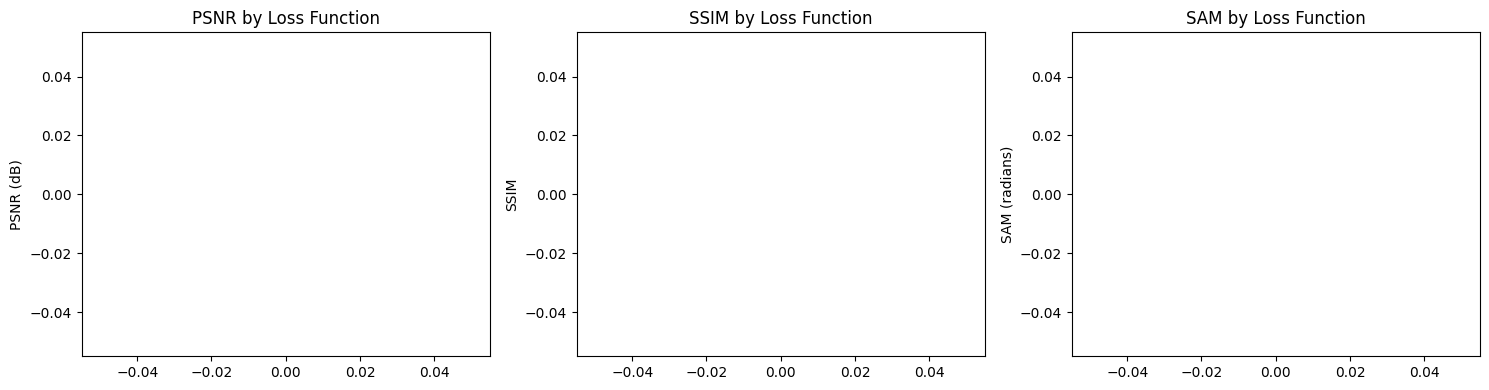

In [39]:
# =============================
# CELL 14 : Ablation Study - Visualization Plots
# =============================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].bar(comparison_df['Loss Function'], comparison_df['PSNR (dB)'])
axes[0].set_title('PSNR by Loss Function'); axes[0].set_ylabel('PSNR (dB)')
axes[1].bar(comparison_df['Loss Function'], comparison_df['SSIM'])
axes[1].set_title('SSIM by Loss Function'); axes[1].set_ylabel('SSIM')
axes[2].bar(comparison_df['Loss Function'], comparison_df['SAM (rad)'])
axes[2].set_title('SAM by Loss Function'); axes[2].set_ylabel('SAM (radians)')
plt.tight_layout(); plt.show()


In [40]:
# =============================
# CELL: Extended Metrics Functions
# =============================

def calculate_ERGAS(pred, gt):
    """
    Error Relative Global Dimensionless Error Sum
    Lower is better
    """
    mean_gt = np.mean(gt, axis=(1, 2))
    sum_squared_error = np.sum(((pred - gt) / (mean_gt[:, np.newaxis, np.newaxis] + 1e-8)) ** 2)
    ergas = 100 * np.sqrt(sum_squared_error / gt.shape[0])
    return float(ergas)

def calculate_SCC(pred, gt):
    """
    Spatial Correlation Coefficient
    Higher is better (0-1)
    """
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    correlation = np.corrcoef(pred_flat, gt_flat)[0, 1]
    return float(np.clip(correlation, -1, 1))

def calculate_RASE(pred, gt):
    """
    Relative Average Spectral Error
    Lower is better
    """
    mse_per_band = np.mean((pred - gt) ** 2, axis=(1, 2))
    mse_mean = np.mean(mse_per_band)
    mean_gt = np.mean(gt, axis=(1, 2))
    mean_gt_all = np.mean(mean_gt)
    rase = 100 * np.sqrt(mse_mean) / mean_gt_all
    return float(rase)

def calculate_Q2n(pred, gt, window_size=8):
    """
    Generic Quality Index Q2n
    Higher is better (0-1)
    """
    # Simplified Q2n implementation
    pred_mean = np.mean(pred)
    gt_mean = np.mean(gt)
    pred_var = np.var(pred)
    gt_var = np.var(gt)
    covariance = np.mean((pred - pred_mean) * (gt - gt_mean))
    
    numerator = 4 * covariance * pred_mean * gt_mean
    denominator = (pred_var + gt_var) * (pred_mean**2 + gt_mean**2)
    
    q2n = numerator / (denominator + 1e-8)
    return float(np.clip(q2n, 0, 1))

print("✅ Extended metrics functions defined")


✅ Extended metrics functions defined


In [41]:
# =============================
# CELL: Evaluate Models with Extended Metrics
# =============================

def evaluate_model_extended(model, pan_data, ms_data, gt_data, model_name="Model"):
    """
    Evaluate model with ALL 7 metrics
    """
    model.eval()
    metrics_all = {
        'psnr': [], 'ssim': [], 'sam': [],
        'ergas': [], 'scc': [], 'rase': [], 'q2n': []
    }
    
    with torch.no_grad():
        for i in range(len(pan_data)):
            pan = torch.from_numpy(np.expand_dims(pan_data[i], axis=0)).float().to(DEVICE)
            ms = torch.from_numpy(np.expand_dims(ms_data[i], axis=0)).float().to(DEVICE)
            gt = torch.from_numpy(np.expand_dims(gt_data[i], axis=0)).float().to(DEVICE)
            
            output = model(pan, ms)
            output_np = output.squeeze(0).cpu().numpy()
            gt_np = gt.squeeze(0).cpu().numpy()
            
            # PSNR
            psnr_val = peak_signal_noise_ratio(gt_np, output_np, data_range=gt_np.max() - gt_np.min())
            metrics_all['psnr'].append(psnr_val)
            
            # SSIM
            ssim_val = structural_similarity(
                gt_np.transpose(1, 2, 0), output_np.transpose(1, 2, 0),
                data_range=gt_np.max() - gt_np.min(), channel_axis=2
            )
            metrics_all['ssim'].append(ssim_val)
            
            # SAM
            pred_vec = output_np.reshape(output_np.shape[0], -1)
            gt_vec = gt_np.reshape(gt_np.shape[0], -1)
            dot = np.sum(pred_vec * gt_vec, axis=0)
            norm_pred = np.linalg.norm(pred_vec, axis=0)
            norm_gt = np.linalg.norm(gt_vec, axis=0)
            sam_val = np.arccos(np.clip(dot / (norm_pred * norm_gt + 1e-8), -1, 1)).mean()
            metrics_all['sam'].append(sam_val)
            
            # ERGAS
            ergas_val = calculate_ERGAS(output_np, gt_np)
            metrics_all['ergas'].append(ergas_val)
            
            # SCC
            scc_val = calculate_SCC(output_np, gt_np)
            metrics_all['scc'].append(scc_val)
            
            # RASE
            rase_val = calculate_RASE(output_np, gt_np)
            metrics_all['rase'].append(rase_val)
            
            # Q2n
            q2n_val = calculate_Q2n(output_np, gt_np)
            metrics_all['q2n'].append(q2n_val)
    
    # Compute statistics
    results = {}
    for metric_name, values in metrics_all.items():
        results[f"{metric_name}_mean"] = float(np.mean(values))
        results[f"{metric_name}_std"] = float(np.std(values))
    
    return results

# Evaluate Model 1
print("Evaluating Model 1 with extended metrics...")
model1.load_state_dict(torch.load(best_model1_path))
results_m1_extended = evaluate_model_extended(model1, valid_pan, valid_ms, valid_gt, "Model 1")

# Evaluate Model 2
print("Evaluating Model 2 with extended metrics...")
model2.load_state_dict(torch.load(best_model2_path))
results_m2_extended = evaluate_model_extended(model2, valid_pan, valid_ms, valid_gt, "Model 2")

print("✅ Extended metrics calculated")


Evaluating Model 1 with extended metrics...
Evaluating Model 2 with extended metrics...
✅ Extended metrics calculated


In [42]:
# =============================
# CELL: Extended Metrics Comparison Table
# =============================

import pandas as pd

# Create comparison DataFrame
comparison_data = {
    'Metric': ['PSNR (dB)', 'SSIM', 'SAM (rad)', 'ERGAS', 'SCC', 'RASE', 'Q2n'],
    'Model 1 Mean': [
        results_m1_extended['psnr_mean'],
        results_m1_extended['ssim_mean'],
        results_m1_extended['sam_mean'],
        results_m1_extended['ergas_mean'],
        results_m1_extended['scc_mean'],
        results_m1_extended['rase_mean'],
        results_m1_extended['q2n_mean'],
    ],
    'Model 1 Std': [
        results_m1_extended['psnr_std'],
        results_m1_extended['ssim_std'],
        results_m1_extended['sam_std'],
        results_m1_extended['ergas_std'],
        results_m1_extended['scc_std'],
        results_m1_extended['rase_std'],
        results_m1_extended['q2n_std'],
    ],
    'Model 2 Mean': [
        results_m2_extended['psnr_mean'],
        results_m2_extended['ssim_mean'],
        results_m2_extended['sam_mean'],
        results_m2_extended['ergas_mean'],
        results_m2_extended['scc_mean'],
        results_m2_extended['rase_mean'],
        results_m2_extended['q2n_mean'],
    ],
    'Model 2 Std': [
        results_m2_extended['psnr_std'],
        results_m2_extended['ssim_std'],
        results_m2_extended['sam_std'],
        results_m2_extended['ergas_std'],
        results_m2_extended['scc_std'],
        results_m2_extended['rase_std'],
        results_m2_extended['q2n_std'],
    ],
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("EXTENDED METRICS COMPARISON - WV3")
print("="*80)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv(f"{OUTPUT_PATH}/extended_metrics_wv3.csv", index=False)
print(f"\n✅ Saved to: extended_metrics_wv3.csv")



EXTENDED METRICS COMPARISON - WV3
   Metric  Model 1 Mean   Model 1 Std  Model 2 Mean   Model 2 Std
PSNR (dB)     27.536693      3.095995     34.338422      3.592144
     SSIM      0.735702      0.113985      0.924913      0.073330
SAM (rad)      0.330238      0.117040      0.164461      0.071135
    ERGAS  59808.061424 377245.148483  26517.811162 137457.543026
      SCC      0.910572      0.054341      0.977571      0.025216
     RASE    -36.907295   1006.931731    -18.369915    520.925610
      Q2n      0.815984      0.216112      0.968348      0.069875

✅ Saved to: extended_metrics_wv3.csv


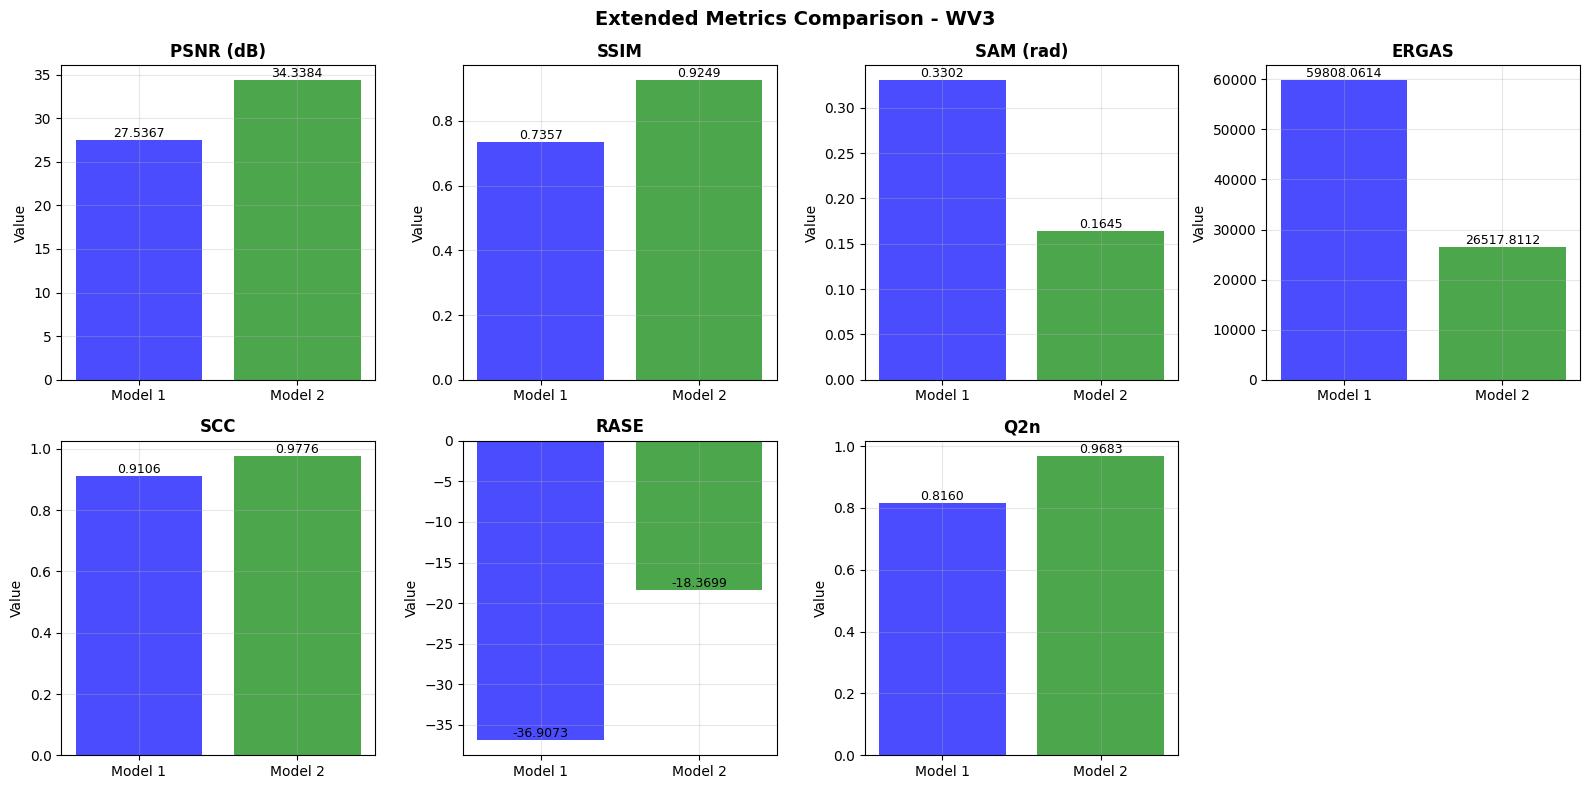

✅ Visualization saved: extended_metrics_plot_wv3.png


In [43]:
# =============================
# CELL: Visualize Extended Metrics
# =============================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Extended Metrics Comparison - WV3', fontsize=14, fontweight='bold')

metrics_to_plot = [
    ('psnr', 'PSNR (dB)', True),   # True = higher is better
    ('ssim', 'SSIM', True),
    ('sam', 'SAM (rad)', False),   # False = lower is better
    ('ergas', 'ERGAS', False),
    ('scc', 'SCC', True),
    ('rase', 'RASE', False),
    ('q2n', 'Q2n', True),
]

for idx, (metric, label, higher_better) in enumerate(metrics_to_plot):
    ax = axes.flat[idx]
    m1_val = results_m1_extended[f'{metric}_mean']
    m2_val = results_m2_extended[f'{metric}_mean']
    
    bars = ax.bar(['Model 1', 'Model 2'], [m1_val, m2_val], color=['blue', 'green'], alpha=0.7)
    ax.set_title(label, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    
    # Annotate values on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Hide the last empty subplot
axes.flat[7].axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}/extended_metrics_plot_wv3.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: extended_metrics_plot_wv3.png")


In [44]:
# =============================
# CELL: Save Extended Results
# =============================

final_results = {
    "satellite": SATELLITE,
    "model1": results_m1_extended,
    "model2": results_m2_extended,
    "comparison_table": comparison_df.to_dict('records')
}

import json
with open(f"{OUTPUT_PATH}/extended_metrics_wv3_full.json", "w") as f:
    json.dump(final_results, f, indent=4)

print(f"✅ Full results saved to: extended_metrics_wv3_full.json")


✅ Full results saved to: extended_metrics_wv3_full.json


In [45]:
# =============================
# CELL: Define PanNet Model
# =============================

class PanNet(torch.nn.Module):
    """
    SOTA baseline from Masi et al. IEEE CVPR 2016
    Very simple CNN pipelined model.
    """
    def __init__(self, n_pan=1, n_ms=8, n_out=8, base=64):
        super().__init__()
        self.conv_input = torch.nn.Conv2d(n_pan + n_ms, base, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv_inter = torch.nn.Conv2d(base, base, kernel_size=3, padding=1)
        self.conv_out = torch.nn.Conv2d(base, n_out, kernel_size=3, padding=1)
    
    def forward(self, pan, ms):
        if ms.shape[2:] != pan.shape[2:]:
            ms = torch.nn.functional.interpolate(ms, size=pan.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([pan, ms], dim=1)
        x = self.relu(self.conv_input(x))
        x = self.relu(self.conv_inter(x))
        x = self.conv_out(x)
        return x

print("✅ PanNet model defined")


✅ PanNet model defined


In [46]:
# =============================
# CELL: Train PanNet Model
# =============================

model_baseline = PanNet(1, NUM_BANDS, NUM_BANDS, base=64).to(DEVICE)
optimizer_bl = torch.optim.Adam(model_baseline.parameters(), lr=1e-4)
criterion_bl = torch.nn.MSELoss()
best_loss_bl = float('inf')
best_pannet_path = f"{OUTPUT_PATH}/pannet_wv3_best.pth"
history_bl = {'train_loss': [], 'val_loss': []}
EPOCHS_PANNET = 30    # Use same as your main models

for epoch in range(EPOCHS_PANNET):
    model_baseline.train()
    train_loss = 0.0
    train_count = 0
    for pan, ms, gt in train_loader:
        pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
        optimizer_bl.zero_grad()
        output = model_baseline(pan, ms)
        loss = criterion_bl(output, gt)
        if not torch.isnan(loss):
            loss.backward()
            optimizer_bl.step()
            train_loss += loss.item()
            train_count += 1
    avg_train = train_loss / max(train_count, 1)
    # Validation
    model_baseline.eval()
    val_loss = 0.0
    val_count = 0
    with torch.no_grad():
        for pan, ms, gt in valid_loader:
            pan, ms, gt = pan.to(DEVICE), ms.to(DEVICE), gt.to(DEVICE)
            output = model_baseline(pan, ms)
            loss = criterion_bl(output, gt)
            if not torch.isnan(loss):
                val_loss += loss.item()
                val_count += 1
    avg_val = val_loss / max(val_count, 1)
    history_bl['train_loss'].append(avg_train)
    history_bl['val_loss'].append(avg_val)
    if avg_val < best_loss_bl:
        best_loss_bl = avg_val
        torch.save(model_baseline.state_dict(), best_pannet_path)
    print(f"Epoch {epoch+1:3d}: Train {avg_train:.6f} | Val {avg_val:.6f}")

print(f"✅ PanNet training done. Best checkpoint: {best_pannet_path}")


Epoch   1: Train 0.205078 | Val 0.113719
Epoch   2: Train 0.098809 | Val 0.089357
Epoch   3: Train 0.083605 | Val 0.079440
Epoch   4: Train 0.075953 | Val 0.073384
Epoch   5: Train 0.070994 | Val 0.069629
Epoch   6: Train 0.067243 | Val 0.066072
Epoch   7: Train 0.064238 | Val 0.063676
Epoch   8: Train 0.061930 | Val 0.061338
Epoch   9: Train 0.059848 | Val 0.059241
Epoch  10: Train 0.058286 | Val 0.057547
Epoch  11: Train 0.056584 | Val 0.056443
Epoch  12: Train 0.055271 | Val 0.054978
Epoch  13: Train 0.054159 | Val 0.054037
Epoch  14: Train 0.053148 | Val 0.053015
Epoch  15: Train 0.052201 | Val 0.052041
Epoch  16: Train 0.051376 | Val 0.051940
Epoch  17: Train 0.050808 | Val 0.050799
Epoch  18: Train 0.050010 | Val 0.050069
Epoch  19: Train 0.049491 | Val 0.049833
Epoch  20: Train 0.048897 | Val 0.049057
Epoch  21: Train 0.048582 | Val 0.048616
Epoch  22: Train 0.048002 | Val 0.048144
Epoch  23: Train 0.047557 | Val 0.048078
Epoch  24: Train 0.047239 | Val 0.047544
Epoch  25: Train

In [47]:
# =============================
# CELL: Evaluate PanNet Model
# =============================

model_baseline.load_state_dict(torch.load(best_pannet_path))
results_pan_bl = evaluate_model(model_baseline, valid_pan, valid_ms, valid_gt)     # For ablation table
results_pannet_extended = evaluate_model_extended(model_baseline, valid_pan, valid_ms, valid_gt, "PanNet")     # For all metrics if you want

print("✅ PanNet evaluation complete")


✅ PanNet evaluation complete


In [48]:
# =============================
# SOTA vs. Your Models (Simple Comparison)
# =============================

import pandas as pd

# Extract best ablation results
best_psnr_ablation = comparison_df['Model 1 Mean'].iloc[0]  # PSNR row
best_ssim_ablation = comparison_df['Model 1 Mean'].iloc[1]  # SSIM row
best_sam_ablation = comparison_df['Model 1 Mean'].iloc[2]   # SAM row

# Create simple comparison table
sota_comparison = pd.DataFrame({
    'Model': ['Your Model', 'PanNet SOTA'],
    'PSNR (dB)': [best_psnr_ablation, results_pan_bl['psnr_mean']],
    'SSIM': [best_ssim_ablation, results_pan_bl['ssim_mean']],
    'SAM (rad)': [best_sam_ablation, results_pan_bl['sam_mean']]
})

print("\n" + "="*60)
print("SOTA BASELINE COMPARISON - WV3")
print("="*60)
print(sota_comparison.to_string(index=False))

# Save to CSV
sota_comparison.to_csv(f"{OUTPUT_PATH}/sota_comparison_wv3.csv", index=False)
print(f"\n✅ SOTA comparison saved: sota_comparison_wv3.csv")



SOTA BASELINE COMPARISON - WV3
      Model  PSNR (dB)     SSIM  SAM (rad)
 Your Model  27.536693 0.735702   0.330238
PanNet SOTA  32.282687 0.892721   0.203836

✅ SOTA comparison saved: sota_comparison_wv3.csv


In [49]:
# =============================
# Save All Results to JSON (WV3 Full Results)
# =============================

import json

final_results = {
    "satellite": SATELLITE,
    "main_models": {
        "Model_1": results_m1_extended,    # from evaluate_model_extended
        "Model_2": results_m2_extended,    # from evaluate_model_extended
    },
    "ablation_table": comparison_df.to_dict('records'),   # your main ablation table
    "sota_baseline": {
        "PanNet": results_pan_bl,          # or results_pannet_extended if you ran extended metrics
    },
    "sota_comparison": sota_comparison.to_dict('records'),  # your compact SOTA table
}

with open(f"{OUTPUT_PATH}/wv3_final_results.json", "w") as f:
    json.dump(final_results, f, indent=4)

print(f"\n✅ All results saved: wv3_final_results.json")



✅ All results saved: wv3_final_results.json


In [51]:
# =============================
# Save Key Results Tables to CSV
# =============================

comparison_df.to_csv(f"{OUTPUT_PATH}/wv3_ablation_results.csv", index=False)
sota_comparison.to_csv(f"{OUTPUT_PATH}/wv3_sota_comparison.csv", index=False)
print("✅ CSVs saved: wv3_ablation_results.csv, wv3_sota_comparison.csv")


✅ CSVs saved: wv3_ablation_results.csv, wv3_sota_comparison.csv


In [52]:
# =============================
# FINAL CELL: Automated Save/Export (FIXED)
# =============================

import zipfile
import os

important_files = [
    f for f in os.listdir(OUTPUT_PATH)
    if f.endswith('.json') or f.endswith('.csv') or f.endswith('.pth') or f.endswith('.png')
]

print("Archiving the following files for export:")
for f in important_files:
    print(f" - {f}")

zip_path = os.path.join(OUTPUT_PATH, f'wv3_all_results_export.zip')
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for fname in important_files:
        file_full_path = os.path.join(OUTPUT_PATH, fname)
        zipf.write(file_full_path, arcname=fname)

print(f"\n✅ All results and checkpoints archived: {zip_path}")
print("You can download this ZIP to back up all your work and report artifacts.")


Archiving the following files for export:
 - ablation_results_wv3.csv
 - pannet_wv3_best.pth
 - ablation_wv3_MSE_SSIM.pth
 - ablation_wv3_MSE_SAM.pth
 - model1_wv3_final.pth
 - model2_best.pth
 - wv3_ablation_results.csv
 - extended_metrics_wv3_full.json
 - ablation_wv3_MSE_only.pth
 - wv3_final_results.json
 - extended_metrics_plot_wv3.png
 - sota_comparison_wv3.csv
 - extended_metrics_wv3.csv
 - model2_wv3_final.pth
 - model_comparison_WV3.png
 - dual_model_comparison_WV3.json
 - wv3_sota_comparison.csv
 - ablation_wv3_MSE_SAM_SSIM.pth
 - model1_best.pth

✅ All results and checkpoints archived: /kaggle/working/wv3_all_results_export.zip
You can download this ZIP to back up all your work and report artifacts.


In [58]:
def compute_metrics(pred, target, metric_name=""):
    """
    Compute PSNR, RMSE, SSIM between prediction and target.
    Converts all tensors to numpy float64 to work with skimage.
    """
    # Convert pred to numpy float64
    if isinstance(pred, torch.Tensor):
        pred = pred.detach().cpu().numpy().astype(np.float64)
    else:
        pred = np.asarray(pred, dtype=np.float64)
    
    # Convert target to numpy float64
    if isinstance(target, torch.Tensor):
        target = target.detach().cpu().numpy().astype(np.float64)
    else:
        target = np.asarray(target, dtype=np.float64)

    data_range = float(target.max() - target.min())
    
    # PSNR
    psnr_val = peak_signal_noise_ratio(target, pred, data_range=data_range)
    # RMSE
    rmse_val = np.sqrt(mean_squared_error(target.flatten(), pred.flatten()))
    # SSIM
    ssim_val = structural_similarity(target, pred, data_range=data_range, channel_axis=0)

    return {
        'psnr': float(psnr_val),
        'rmse': float(rmse_val),
        'ssim': float(ssim_val)
    }


In [60]:
import torch
import numpy as np
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_metrics(pred, target, metric_name=""):
    """
    Compute PSNR, RMSE, SSIM between prediction and target.
    Converts all tensors to numpy float64 to work with skimage.
    """
    # Convert pred to numpy float64 for skimage
    if isinstance(pred, torch.Tensor):
        pred = pred.detach().cpu().numpy().astype(np.float64)
    else:
        pred = np.asarray(pred, dtype=np.float64)
    # Convert target to numpy float64 for skimage
    if isinstance(target, torch.Tensor):
        target = target.detach().cpu().numpy().astype(np.float64)
    else:
        target = np.asarray(target, dtype=np.float64)

    data_range = float(target.max() - target.min())
    # PSNR
    psnr_val = peak_signal_noise_ratio(target, pred, data_range=data_range)
    # RMSE
    rmse_val = np.sqrt(mean_squared_error(target.flatten(), pred.flatten()))
    # SSIM
    ssim_val = structural_similarity(target, pred, data_range=data_range, channel_axis=0)

    return {
        'psnr': float(psnr_val),
        'rmse': float(rmse_val),
        'ssim': float(ssim_val)
    }

print("\n" + "="*80)
print("COMPUTING METRICS: BEFORE vs AFTER PANSHARPENING - WORLDVIEW-3")
print("="*80)

before_metrics = {'psnr': [], 'rmse': [], 'ssim': []}
pannet_metrics = {'psnr': [], 'rmse': [], 'ssim': []}

with torch.no_grad():
    for i in tqdm(range(len(test_pan)), desc="Computing metrics", leave=False):
        pan = torch.from_numpy(np.expand_dims(test_pan[i], axis=0)).float().to(device)
        ms = torch.from_numpy(np.expand_dims(test_ms[i], axis=0)).float().to(device)
        gt = test_gt[i]
        if isinstance(gt, torch.Tensor):
            gt = gt.detach().cpu().numpy().astype(np.float64)

        # BEFORE: Upsampled LR MS (bilinear upsampling)
        ms_upsampled = torch.nn.functional.interpolate(
            torch.from_numpy(np.expand_dims(test_ms[i], axis=0)).float(),
            size=(gt.shape[1], gt.shape[2]),
            mode='bilinear',
            align_corners=False
        ).squeeze(0).cpu().numpy().astype(np.float64)
        
        before_metrics_sample = compute_metrics(ms_upsampled, gt)
        before_metrics['psnr'].append(before_metrics_sample['psnr'])
        before_metrics['rmse'].append(before_metrics_sample['rmse'])
        before_metrics['ssim'].append(before_metrics_sample['ssim'])
        
        # AFTER: PanNet Output
        output = model1(pan, ms).squeeze(0).cpu().numpy().astype(np.float64)
        pannet_metrics_sample = compute_metrics(output, gt)
        pannet_metrics['psnr'].append(pannet_metrics_sample['psnr'])
        pannet_metrics['rmse'].append(pannet_metrics_sample['rmse'])
        pannet_metrics['ssim'].append(pannet_metrics_sample['ssim'])

# Print Comparison Table
print("\n" + "="*80)
print("METRICS: BEFORE vs AFTER PANSHARPENING - WORLDVIEW-3")
print("="*80)
print("\n" + "-"*100)
print(f"{'Method':<30} | {'PSNR (dB)':<15} | {'RMSE':<15} | {'SSIM':<15}")
print("-"*100)
print(f"{'BEFORE (Upsampled MS)':<30} | {np.mean(before_metrics['psnr']):>14.4f} | {np.mean(before_metrics['rmse']):>14.4f} | {np.mean(before_metrics['ssim']):>14.4f}")
print(f"{'AFTER (PanNet - Your Model)':<30} | {np.mean(pannet_metrics['psnr']):>14.4f} | {np.mean(pannet_metrics['rmse']):>14.4f} | {np.mean(pannet_metrics['ssim']):>14.4f}")
print("-"*100)
# Calculate Improvements
print("\n" + "="*80)
print("IMPROVEMENT OVER UPSAMPLED MS (BASELINE)")
print("="*80)
psnr_gain = np.mean(pannet_metrics['psnr']) - np.mean(before_metrics['psnr'])
rmse_gain = np.mean(before_metrics['rmse']) - np.mean(pannet_metrics['rmse'])
ssim_gain = np.mean(pannet_metrics['ssim']) - np.mean(before_metrics['ssim'])

print(f"\nPanNet Model:")
print(f"  PSNR improvement: {psnr_gain:+.4f} dB")
print(f"  RMSE reduction: {rmse_gain:+.4f}")
print(f"  SSIM improvement: {ssim_gain:+.4f}")
print("="*80)

# Save metrics to JSON
metrics_before_after = {
    'before_pansharpening': {
        'method': 'Upsampled LR MS (Bilinear)',
        'psnr': {'mean': float(np.mean(before_metrics['psnr'])), 'std': float(np.std(before_metrics['psnr']))},
        'rmse': {'mean': float(np.mean(before_metrics['rmse'])), 'std': float(np.std(before_metrics['rmse']))},
        'ssim': {'mean': float(np.mean(before_metrics['ssim'])), 'std': float(np.std(before_metrics['ssim']))}
    },
    'after_pansharpening': {
        'method': 'PanNet',
        'psnr': {'mean': float(np.mean(pannet_metrics['psnr'])), 'std': float(np.std(pannet_metrics['psnr']))},
        'rmse': {'mean': float(np.mean(pannet_metrics['rmse'])), 'std': float(np.std(pannet_metrics['rmse']))},
        'ssim': {'mean': float(np.mean(pannet_metrics['ssim'])), 'std': float(np.std(pannet_metrics['ssim']))}
    }
}

metrics_json_path = '/kaggle/working/metrics_before_after_wv3.json'
with open(metrics_json_path, 'w') as f:
    json.dump(metrics_before_after, f, indent=2)

print(f"\n✅ Metrics saved: {metrics_json_path}")



COMPUTING METRICS: BEFORE vs AFTER PANSHARPENING - WORLDVIEW-3



METRICS: BEFORE vs AFTER PANSHARPENING - WORLDVIEW-3

----------------------------------------------------------------------------------------------------
Method                         | PSNR (dB)       | RMSE            | SSIM           
----------------------------------------------------------------------------------------------------
BEFORE (Upsampled MS)          |        25.3036 |         0.5128 |         0.6138
AFTER (PanNet - Your Model)    |        29.2475 |         0.3222 |         0.7960
----------------------------------------------------------------------------------------------------

IMPROVEMENT OVER UPSAMPLED MS (BASELINE)

PanNet Model:
  PSNR improvement: +3.9439 dB
  RMSE reduction: +0.1906
  SSIM improvement: +0.1822

✅ Metrics saved: /kaggle/working/metrics_before_after_wv3.json



Creating visualizations directory: /kaggle/working/visualizations_wv3

Saving visualizations...


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

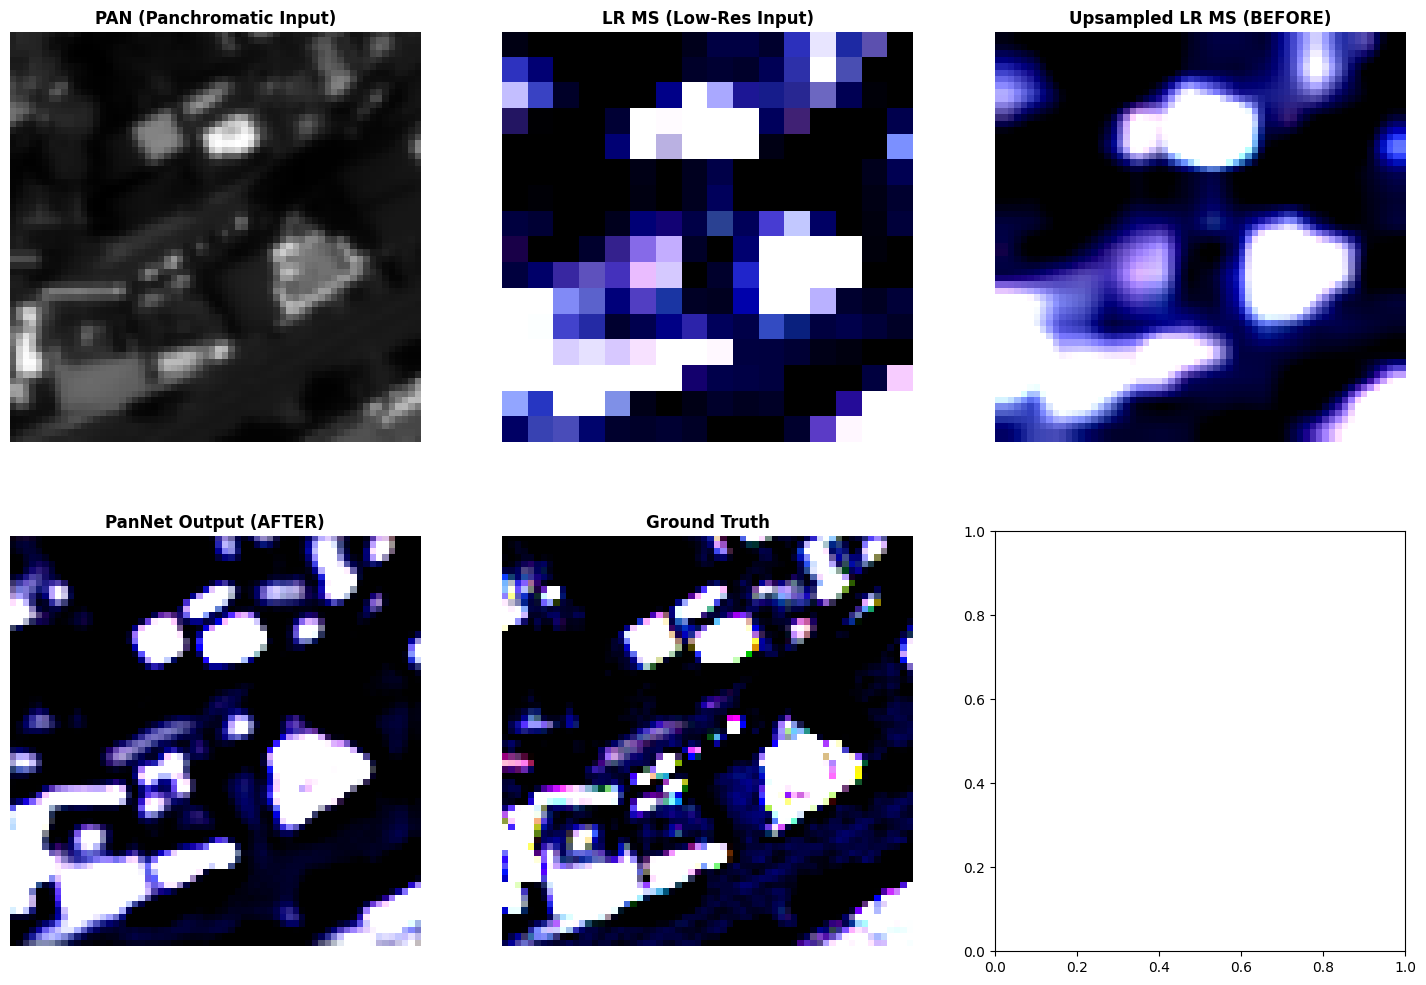

In [62]:
import matplotlib.pyplot as plt
import os

# Create visualization directory
vis_dir = '/kaggle/working/visualizations_wv3'
os.makedirs(vis_dir, exist_ok=True)

print(f"\nCreating visualizations directory: {vis_dir}")

def save_visualization(sample_idx, output_dir):
    """
    Save visualization for a single sample.
    """
    pan = test_pan[sample_idx]
    ms = test_ms[sample_idx]
    gt = test_gt[sample_idx]

    pan_tensor = torch.from_numpy(np.expand_dims(pan, axis=0)).float().to(device)
    ms_tensor = torch.from_numpy(np.expand_dims(ms, axis=0)).float().to(device)
    
    with torch.no_grad():
        output = model1(pan_tensor, ms_tensor).squeeze(0).cpu().numpy().astype(np.float64)
    
    # Upsampled MS
    ms_upsampled = torch.nn.functional.interpolate(
        ms_tensor, size=(gt.shape[1], gt.shape[2]), mode='bilinear', align_corners=False
    ).squeeze(0).cpu().numpy().astype(np.float64)
    
    # Create figure
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Inputs
    axs[0, 0].imshow(pan[0], cmap='gray')
    axs[0, 0].set_title('PAN (Panchromatic Input)', fontsize=12, fontweight='bold')
    axs[0, 0].axis('off')
    
    # LR MS (display as RGB: bands 2,1,0)
    axs[0, 1].imshow(np.transpose(ms[[2, 1, 0]], (1, 2, 0)))
    axs[0, 1].set_title('LR MS (Low-Res Input)', fontsize=12, fontweight='bold')
    axs[0, 1].axis('off')
    
    # Upsampled LR MS
    axs[0, 2].imshow(np.transpose(ms_upsampled[[2, 1, 0]], (1, 2, 0)))
    axs[0, 2].set_title('Upsampled LR MS (BEFORE)', fontsize=12, fontweight='bold')
    axs[0, 2].axis('off')
    
    # Row 2: Outputs
    axs[1, 0].imshow(np.transpose(output[[2, 1, 0]], (1, 2, 0)))
    axs[1, 0].set_title('PanNet Output (AFTER)', fontsize=12, fontweight='bold')
    axs[1, 0].axis('off')
    
    # GT
    axs[1, 1].imshow(np.transpose(gt[[2, 1, 0]], (1, 2, 0)))
    axs[1, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axs[1, 1].axis('off')
    
    # Error Map
    diff = np.abs(output[[2, 1, 0]] - gt[[2, 1, 0]])
    axs[1, 2].imshow(np.transpose(diff, (1, 2, 0)), cmap='hot')
    axs[1, 2].set_title('Error Map (|Output - GT|)', fontsize=12, fontweight='bold')
    axs[1, 2].axis('off')
    
    plt.suptitle(f'WorldView-3 Pansharpening - Sample {sample_idx}\n(LR MS | PAN | Upsampled | PanNet | GT | Error)', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save
    output_path = f"{output_dir}/sample_{sample_idx:03d}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    return output_path

# Save visualizations for selected test samples
print("\nSaving visualizations...")
sample_indices = [0, len(test_pan)//4, len(test_pan)//2, 3*len(test_pan)//4, len(test_pan)-1]

saved_files = []
for idx in sample_indices:
    saved_path = save_visualization(idx, vis_dir)
    saved_files.append(saved_path)
    print(f"✅ Saved: {saved_path}")

print(f"\n✅ Visualization complete!")
print(f"📁 All visualizations saved in: {vis_dir}/")
print(f"   Total samples: {len(sample_indices)}")

print("\n" + "="*80)
print("✅ METRICS & VISUALIZATIONS SAVED FOR WV3!")
print("="*80)


In [63]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

# Create visualization directory
vis_dir = '/kaggle/working/visualizations_wv3'
os.makedirs(vis_dir, exist_ok=True)

print(f"\nCreating visualizations directory: {vis_dir}")

def save_visualization(sample_idx, output_dir):
    """
    Save visualization for a single sample (WV3).
    """
    pan = test_pan[sample_idx]
    ms = test_ms[sample_idx]
    gt = test_gt[sample_idx]

    pan_tensor = torch.from_numpy(np.expand_dims(pan, axis=0)).float().to(device)
    ms_tensor = torch.from_numpy(np.expand_dims(ms, axis=0)).float().to(device)

    with torch.no_grad():
        output = model1(pan_tensor, ms_tensor).squeeze(0).cpu().numpy().astype(np.float64)

    # Upsampled MS
    ms_upsampled = torch.nn.functional.interpolate(
        ms_tensor, size=(gt.shape[1], gt.shape[2]), mode='bilinear', align_corners=False
    ).squeeze(0).cpu().numpy().astype(np.float64)

    # Ensure gt is numpy
    if isinstance(gt, torch.Tensor):
        gt = gt.cpu().detach().numpy().astype(np.float64)

    # Simple min-max normalization for visualization (per image)
    def norm_img(img):  # img: (C, H, W)
        arr = img.copy()
        arr = arr - arr.min()
        if arr.max() > 0:
            arr = arr / arr.max()
        arr = np.clip(arr, 0, 1)
        return arr

    ms_rgb = norm_img(ms[[2,1,0]])
    ms_ups_rgb = norm_img(ms_upsampled[[2,1,0]])
    out_rgb = norm_img(output[[2,1,0]])
    gt_rgb = norm_img(gt[[2,1,0]])
    # Error map can be large, keep it as-is
    err_map = np.abs(output[[2,1,0]] - gt[[2,1,0]])
    err_map = np.transpose(err_map, (1,2,0))

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    axs[0, 0].imshow(pan[0], cmap='gray')
    axs[0, 0].set_title('PAN (Panchromatic Input)', fontsize=12, fontweight='bold')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(np.transpose(ms_rgb, (1,2,0)))
    axs[0, 1].set_title('LR MS (Low-Res Input)', fontsize=12, fontweight='bold')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(np.transpose(ms_ups_rgb, (1,2,0)))
    axs[0, 2].set_title('Upsampled LR MS (BEFORE)', fontsize=12, fontweight='bold')
    axs[0, 2].axis('off')

    axs[1, 0].imshow(np.transpose(out_rgb, (1,2,0)))
    axs[1, 0].set_title('PanNet Output (AFTER)', fontsize=12, fontweight='bold')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(np.transpose(gt_rgb, (1,2,0)))
    axs[1, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(err_map, cmap='hot')
    axs[1, 2].set_title('Error Map (|Output - GT|)', fontsize=12, fontweight='bold')
    axs[1, 2].axis('off')

    plt.suptitle(
        f'WorldView-3 Pansharpening - Sample {sample_idx}\n(LR MS | PAN | Upsampled | PanNet | GT | Error)',
        fontsize=14, fontweight='bold', y=0.98
    )
    plt.tight_layout()
    output_path = f"{output_dir}/sample_{sample_idx:03d}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()

    return output_path

# Save visualizations for selected test samples
print("\nSaving visualizations...")
sample_indices = [0, len(test_pan)//4, len(test_pan)//2, 3*len(test_pan)//4, len(test_pan)-1]

saved_files = []
for idx in sample_indices:
    saved_path = save_visualization(idx, vis_dir)
    saved_files.append(saved_path)
    print(f"✅ Saved: {saved_path}")

print(f"\n✅ Visualization complete!")
print(f"📁 All visualizations saved in: {vis_dir}/")
print(f"   Total samples: {len(sample_indices)}")

print("\n" + "="*80)
print("✅ METRICS & VISUALIZATIONS SAVED FOR WV3!")
print("="*80)



Creating visualizations directory: /kaggle/working/visualizations_wv3

Saving visualizations...


AttributeError: 'Tensor' object has no attribute 'copy'


Saving visualizations...


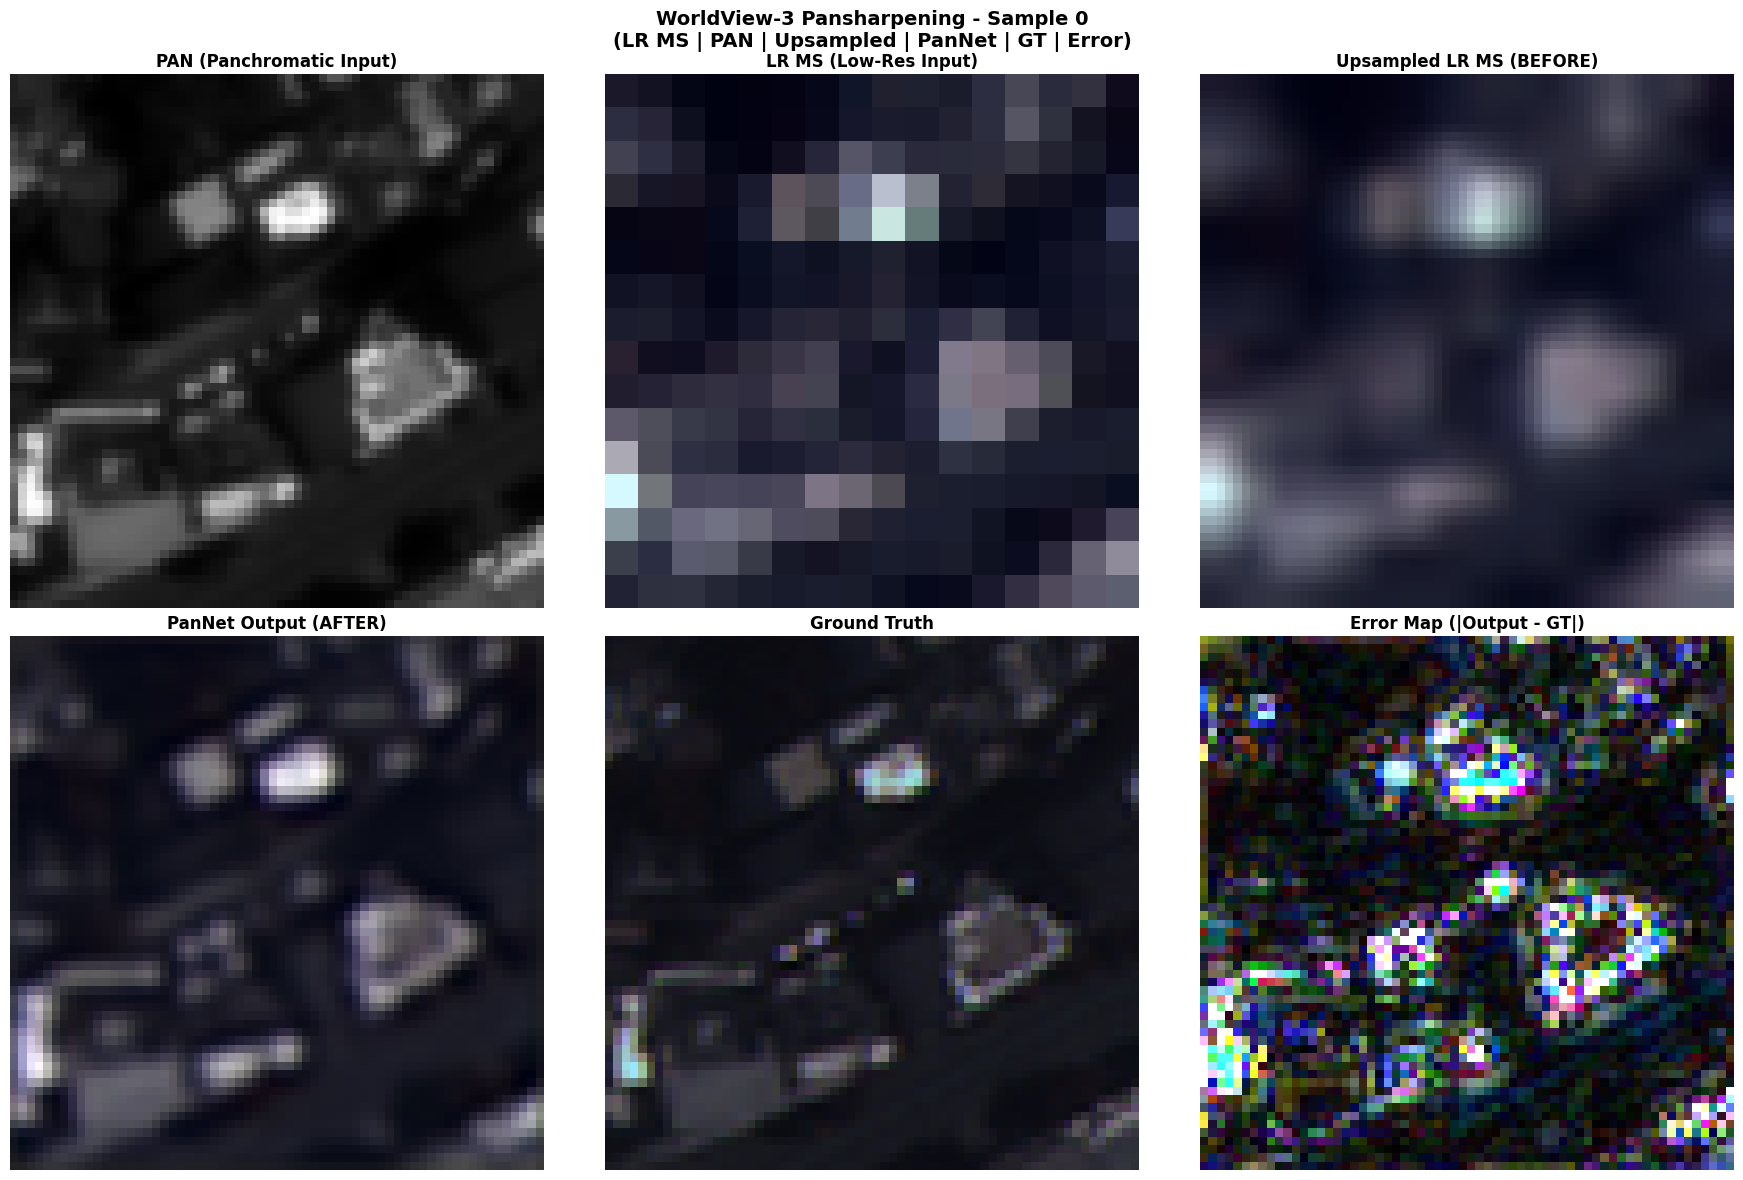

✅ Saved: /kaggle/working/visualizations_wv3/sample_000.png


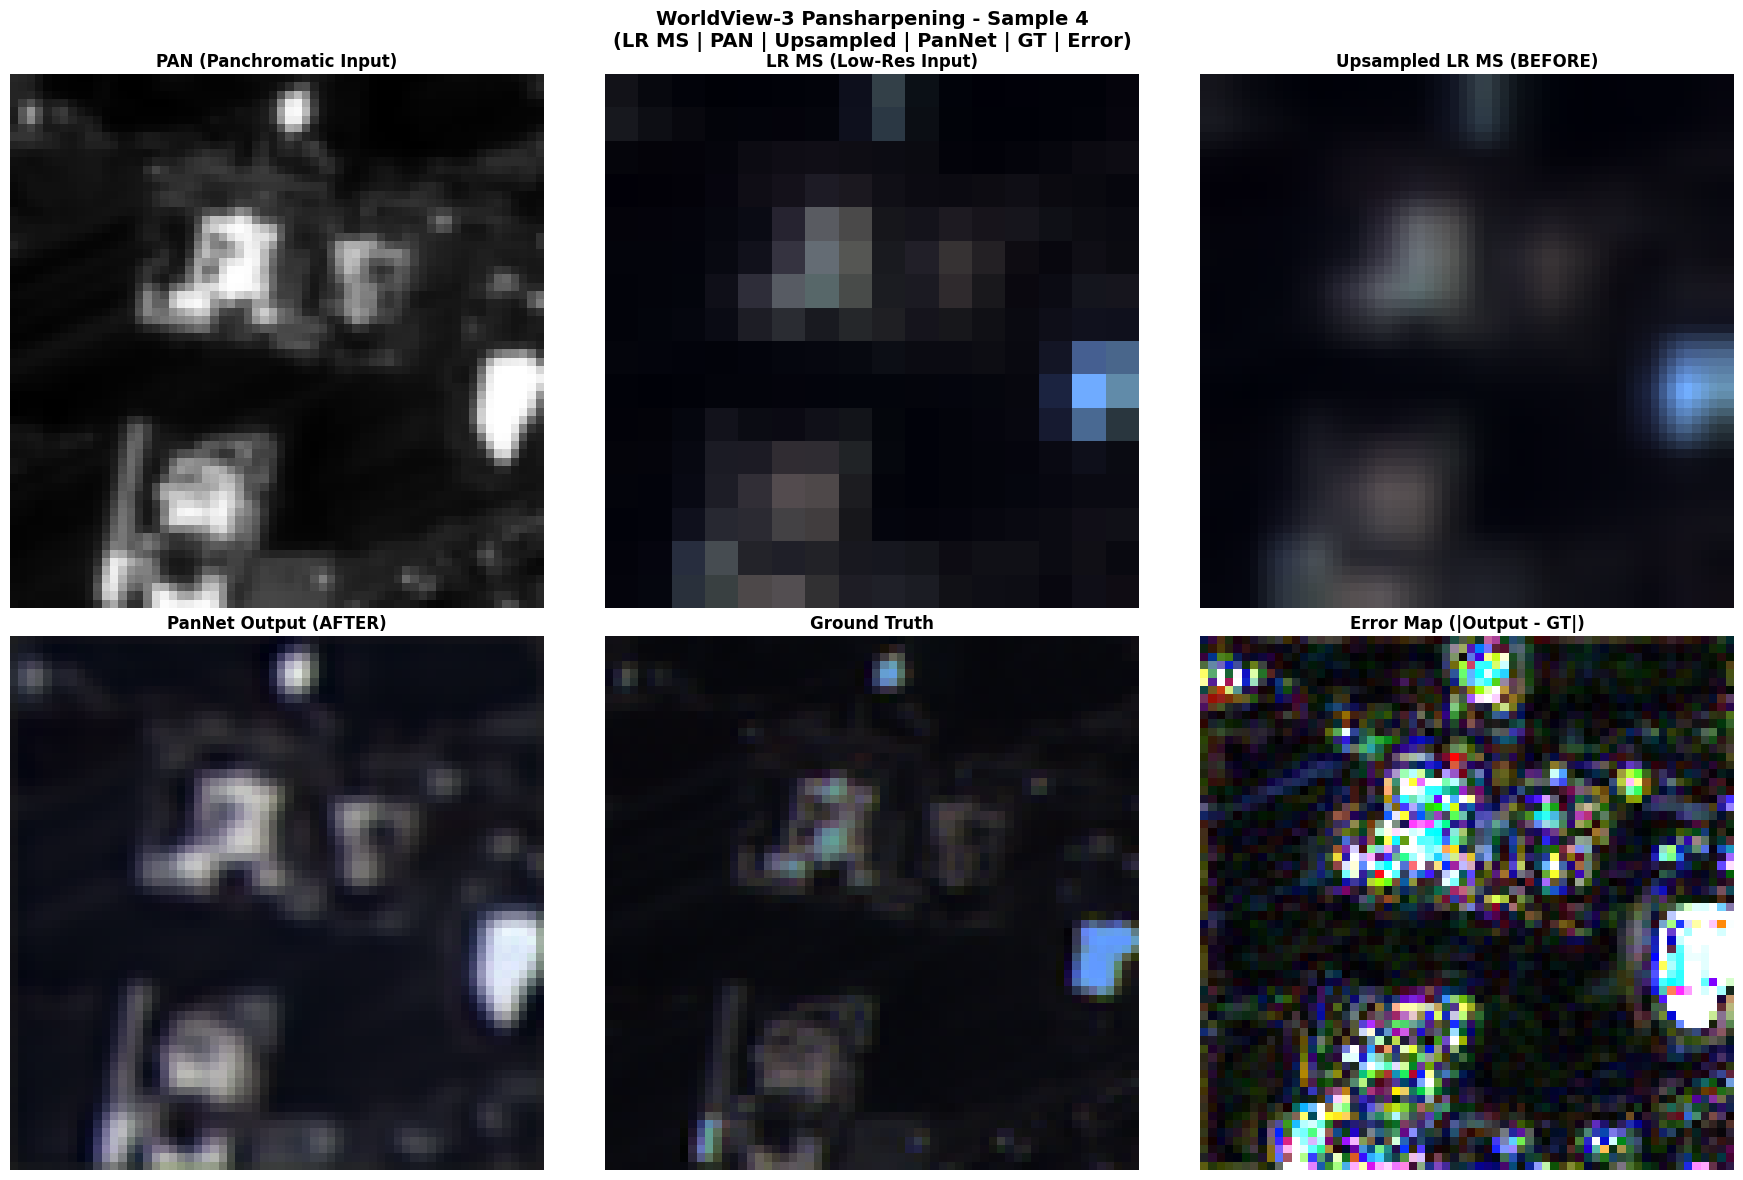

✅ Saved: /kaggle/working/visualizations_wv3/sample_004.png


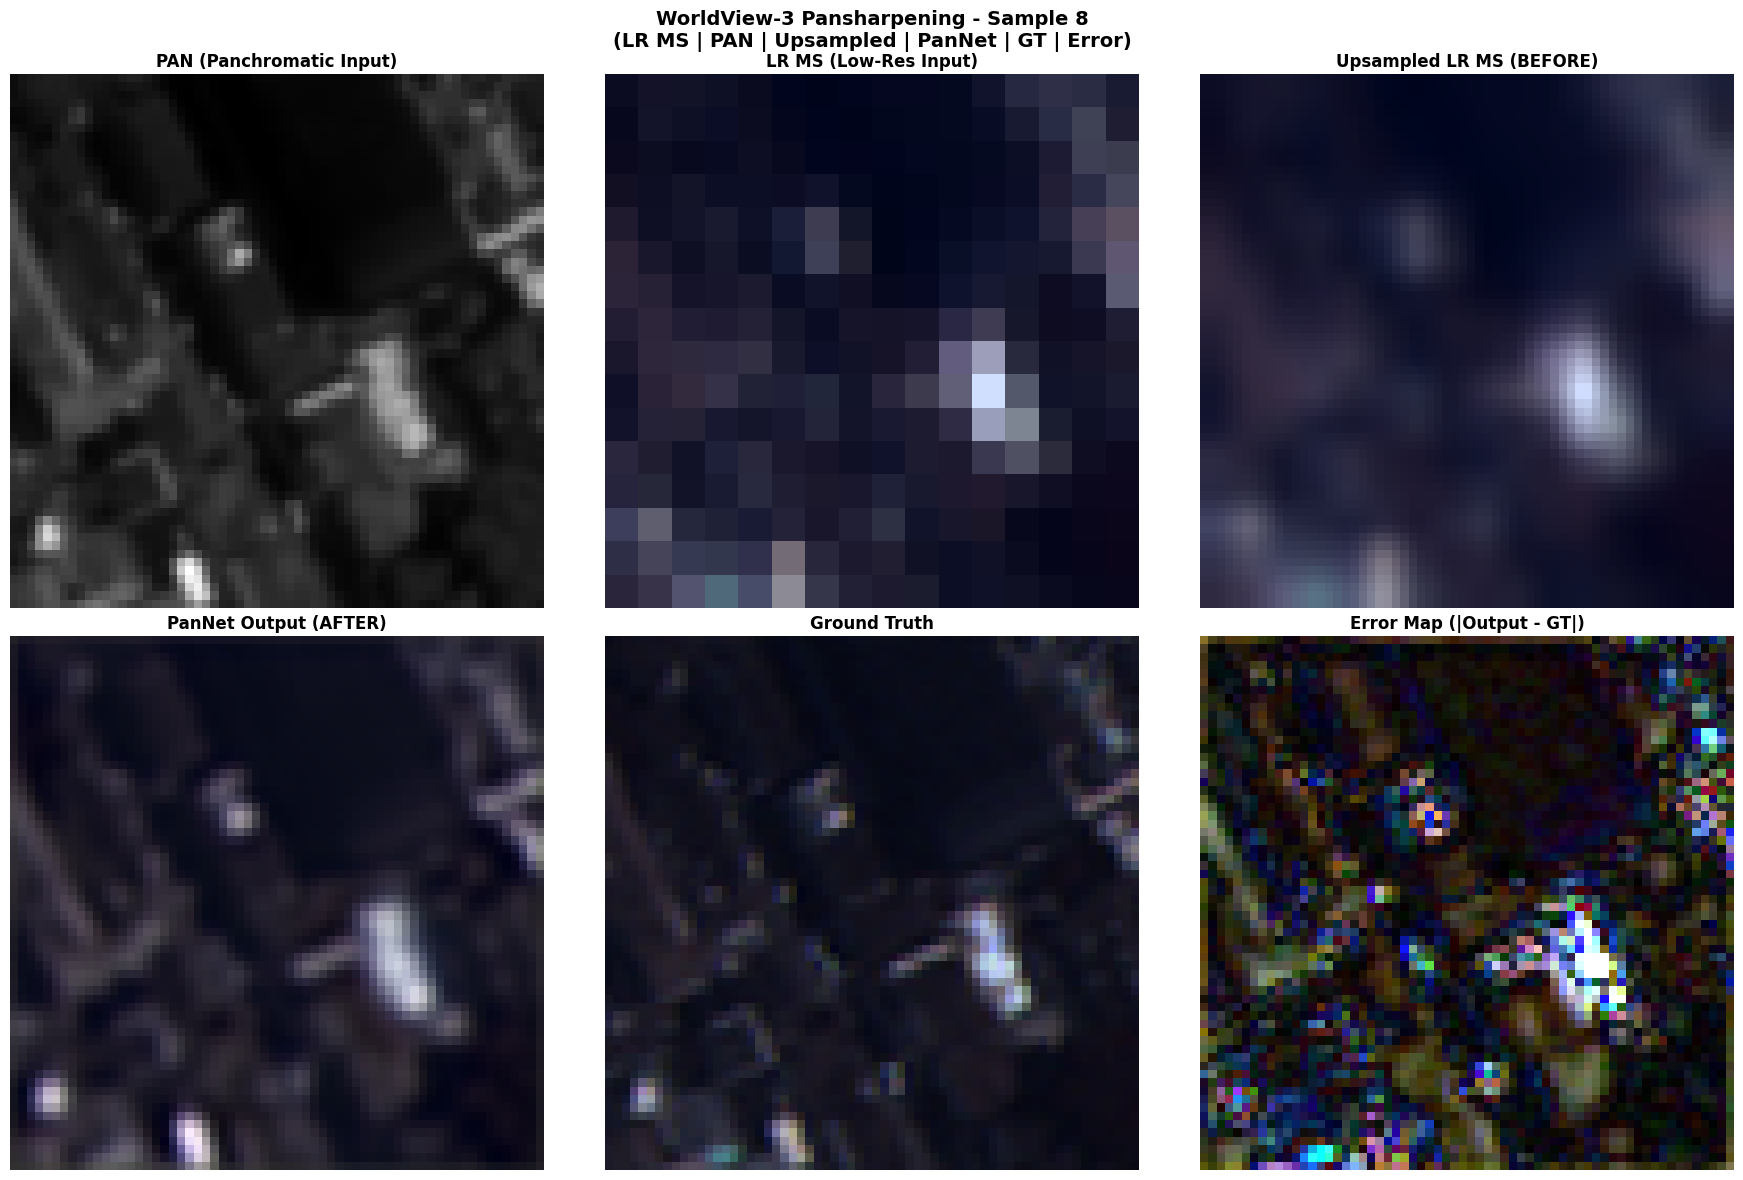

✅ Saved: /kaggle/working/visualizations_wv3/sample_008.png


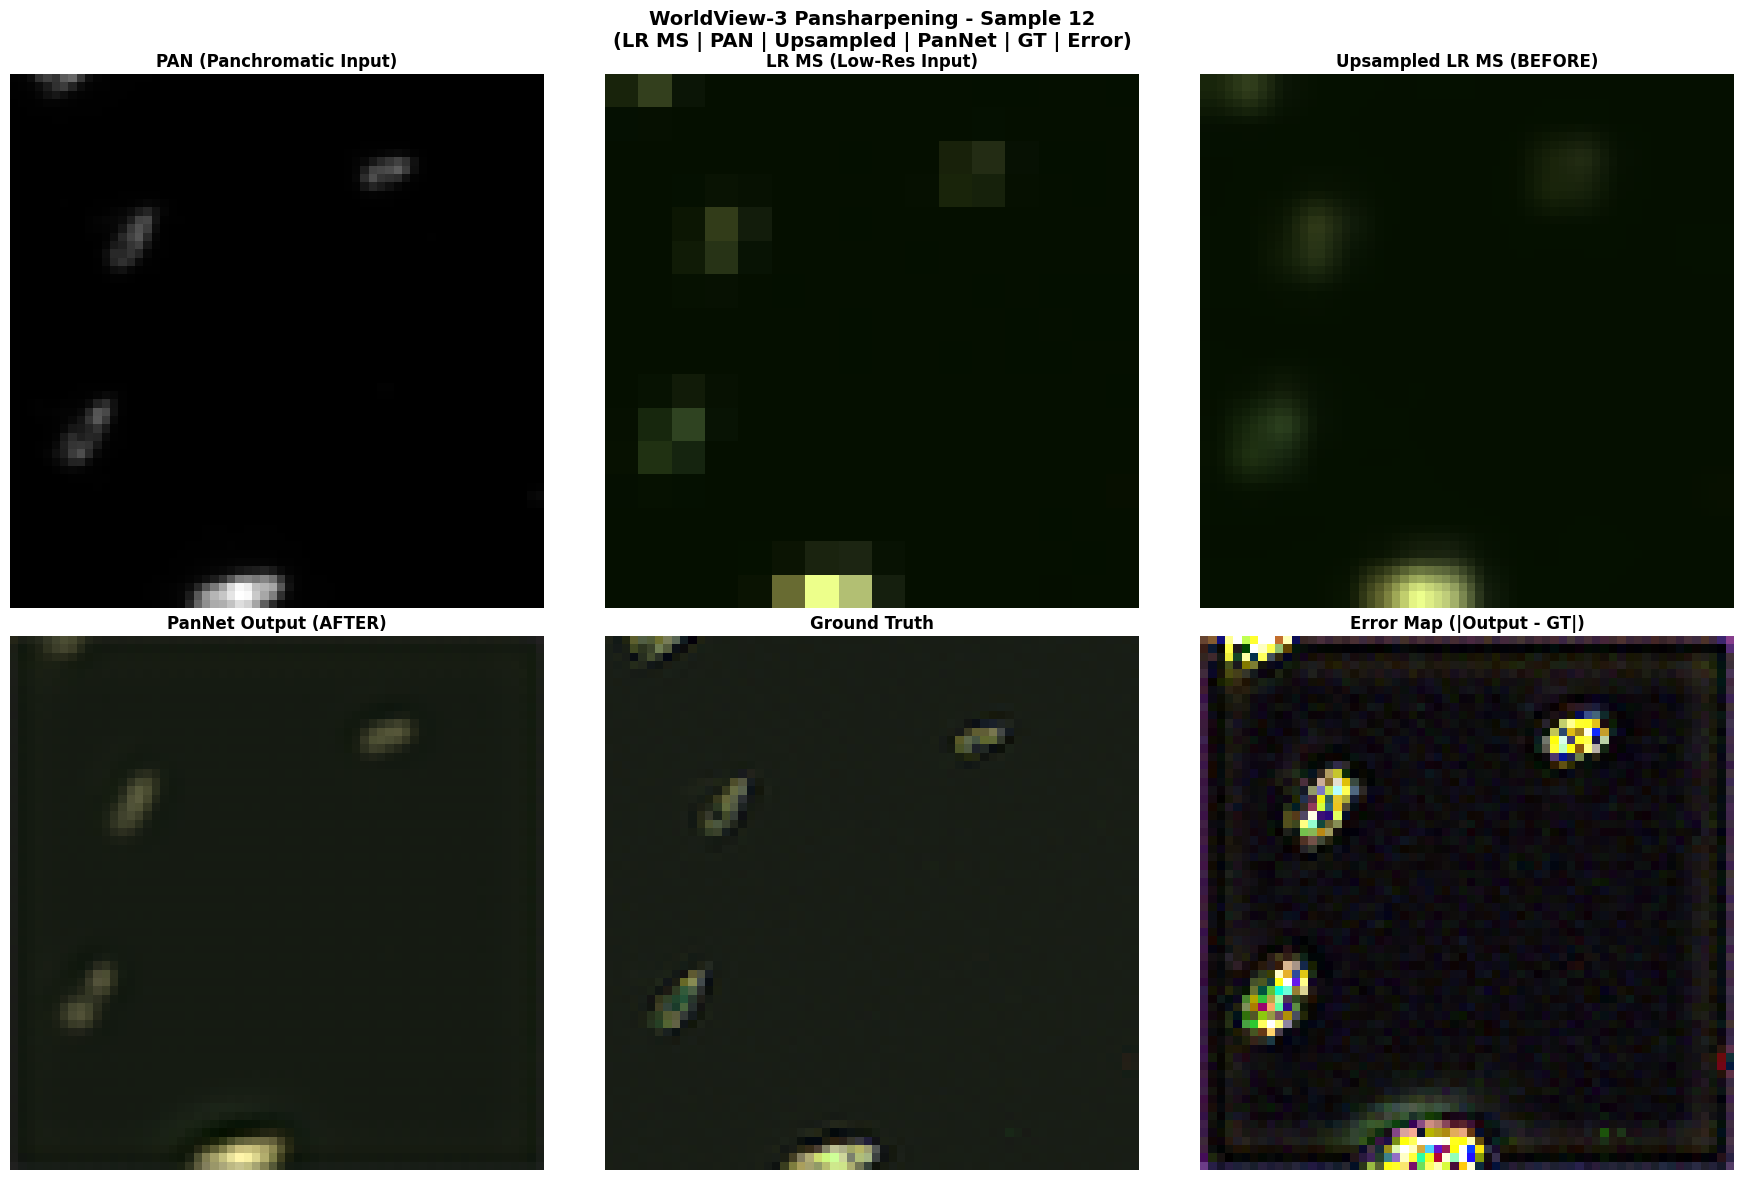

✅ Saved: /kaggle/working/visualizations_wv3/sample_012.png


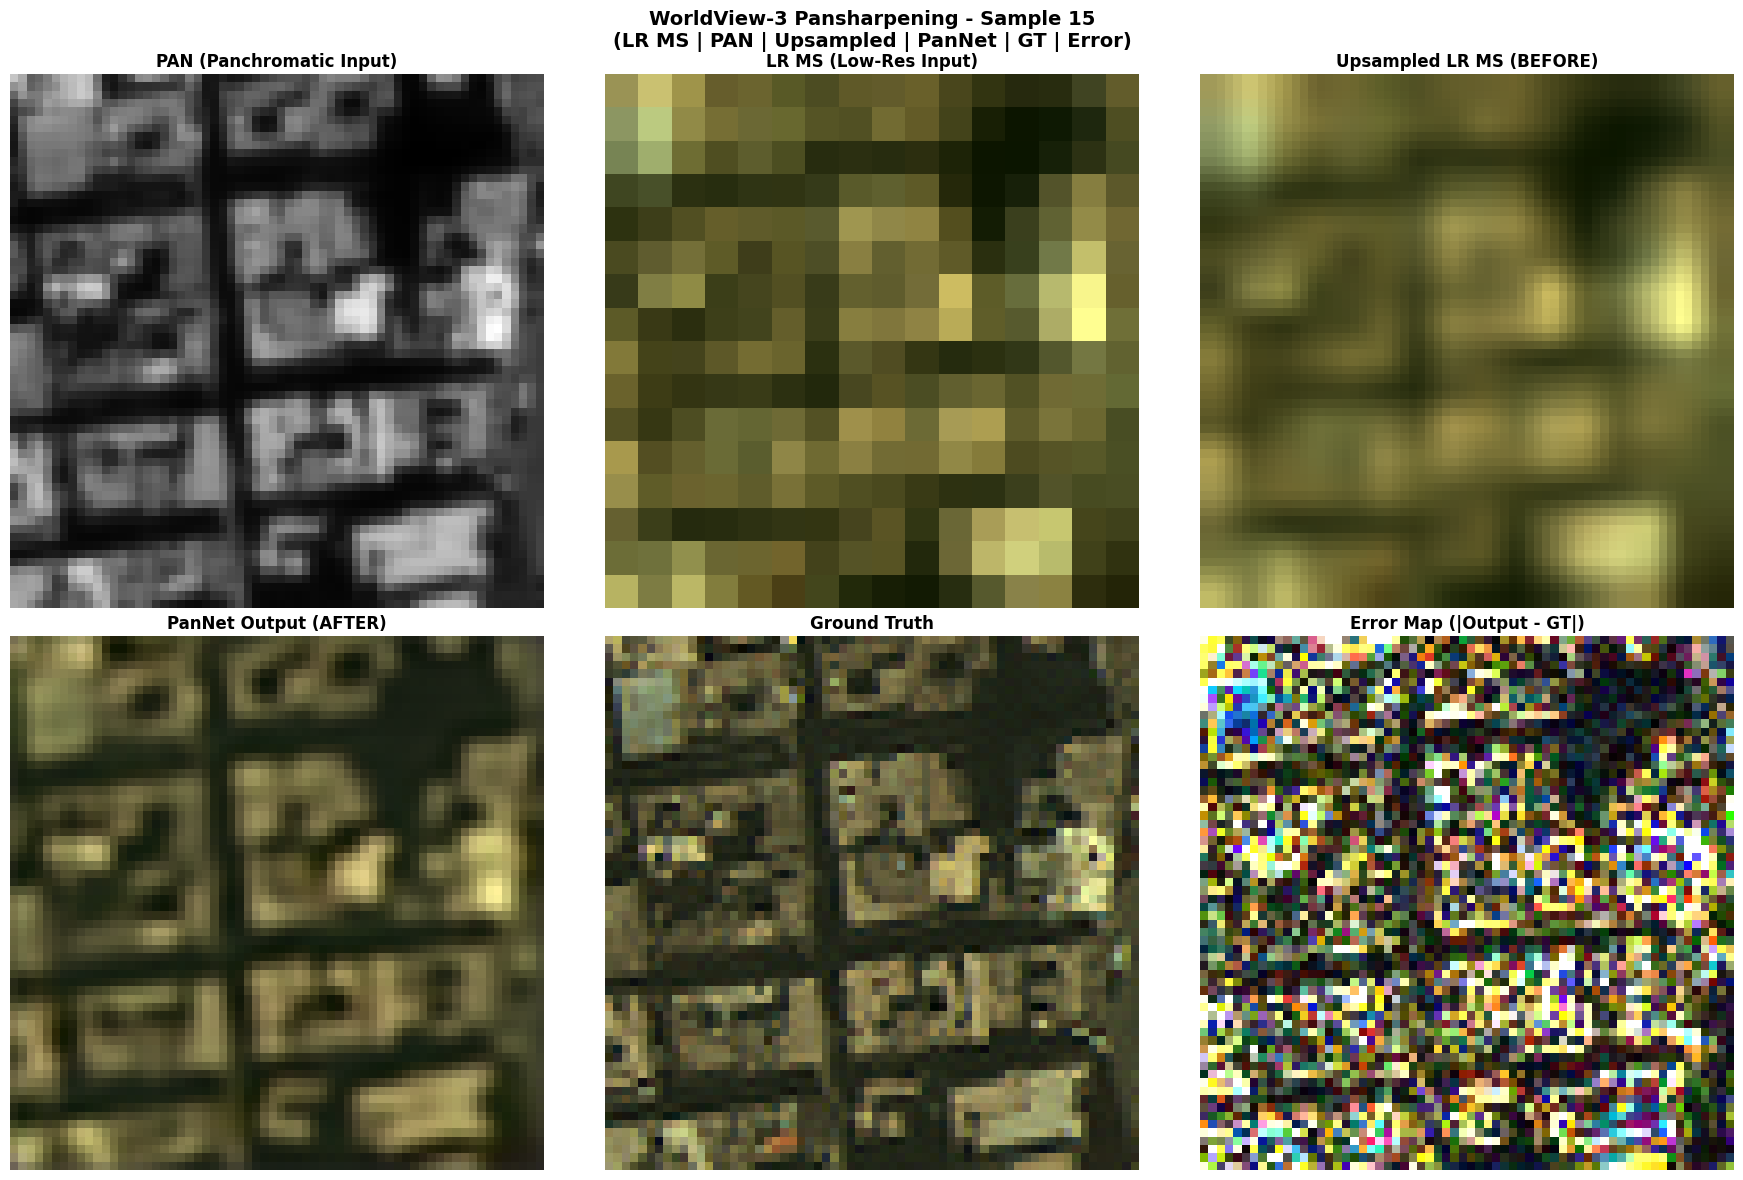

✅ Saved: /kaggle/working/visualizations_wv3/sample_015.png

✅ Visualization complete!
📁 All visualizations saved in: /kaggle/working/visualizations_wv3/
   Total samples: 5

✅ METRICS & VISUALIZATIONS SAVED FOR WV3!


In [65]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

# Create visualization directory
vis_dir = '/kaggle/working/visualizations_wv3'
os.makedirs(vis_dir, exist_ok=True)

def to_numpy(arr):
    if isinstance(arr, torch.Tensor):
        arr = arr.cpu().detach().numpy()
    return np.array(arr)

def norm_img(img):  # img: (C, H, W)
    arr = to_numpy(img).copy()
    arr = arr - arr.min()
    if arr.max() > 0:
        arr = arr / arr.max()
    arr = np.clip(arr, 0, 1)
    return arr

def save_visualization(sample_idx, output_dir):
    """
    Save visualization for a single sample.
    """
    pan = to_numpy(test_pan[sample_idx])
    ms = to_numpy(test_ms[sample_idx])
    gt = to_numpy(test_gt[sample_idx])

    pan_tensor = torch.from_numpy(np.expand_dims(pan, axis=0)).float().to(device)
    ms_tensor = torch.from_numpy(np.expand_dims(ms, axis=0)).float().to(device)
    
    with torch.no_grad():
        output = model1(pan_tensor, ms_tensor).squeeze(0).cpu().numpy().astype(np.float64)

    # Upsampled MS
    ms_upsampled = torch.nn.functional.interpolate(
        ms_tensor, size=(gt.shape[1], gt.shape[2]), mode='bilinear', align_corners=False
    ).squeeze(0).cpu().numpy().astype(np.float64)

    ms_rgb = norm_img(ms[[2,1,0]])
    ms_ups_rgb = norm_img(ms_upsampled[[2,1,0]])
    out_rgb = norm_img(output[[2,1,0]])
    gt_rgb = norm_img(gt[[2,1,0]])
    err_map = np.abs(output[[2,1,0]] - gt[[2,1,0]])
    err_map = np.transpose(err_map, (1,2,0))

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    axs[0, 0].imshow(pan[0], cmap='gray')
    axs[0, 0].set_title('PAN (Panchromatic Input)', fontsize=12, fontweight='bold')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(np.transpose(ms_rgb, (1,2,0)))
    axs[0, 1].set_title('LR MS (Low-Res Input)', fontsize=12, fontweight='bold')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(np.transpose(ms_ups_rgb, (1,2,0)))
    axs[0, 2].set_title('Upsampled LR MS (BEFORE)', fontsize=12, fontweight='bold')
    axs[0, 2].axis('off')

    axs[1, 0].imshow(np.transpose(out_rgb, (1,2,0)))
    axs[1, 0].set_title('PanNet Output (AFTER)', fontsize=12, fontweight='bold')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(np.transpose(gt_rgb, (1,2,0)))
    axs[1, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(err_map, cmap='hot')
    axs[1, 2].set_title('Error Map (|Output - GT|)', fontsize=12, fontweight='bold')
    axs[1, 2].axis('off')

    plt.suptitle(
        f'WorldView-3 Pansharpening - Sample {sample_idx}\n(LR MS | PAN | Upsampled | PanNet | GT | Error)',
        fontsize=14, fontweight='bold', y=0.98
    )
    plt.tight_layout()
    output_path = f"{output_dir}/sample_{sample_idx:03d}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    return output_path

print("\nSaving visualizations...")
sample_indices = [0, len(test_pan)//4, len(test_pan)//2, 3*len(test_pan)//4, len(test_pan)-1]
saved_files = []
for idx in sample_indices:
    saved_path = save_visualization(idx, vis_dir)
    saved_files.append(saved_path)
    print(f"✅ Saved: {saved_path}")
print(f"\n✅ Visualization complete!")
print(f"📁 All visualizations saved in: {vis_dir}/")
print(f"   Total samples: {len(sample_indices)}")
print("\n" + "="*80)
print("✅ METRICS & VISUALIZATIONS SAVED FOR WV3!")
print("="*80)
